In [107]:
import gc
import time
import math
import datetime
from math import log, floor
from sklearn.neighbors import KDTree

import numpy as np
import pandas as pd
from pathlib import Path
from sklearn.utils import shuffle
from tqdm import tqdm as tqdm

import seaborn as sns
from matplotlib import colors
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize

import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
from plotly.subplots import make_subplots

import pywt
from statsmodels.robust import mad

import scipy
from scipy import stats
import statsmodels
from scipy import signal
import statsmodels.api as sm
# from fbprophet import Prophet
from scipy.signal import butter, deconvolve
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt

import warnings
warnings.filterwarnings("ignore")

In [108]:
military=pd.read_csv("train_hackerearth.csv")

In [109]:
military.shape

(10000, 12)

In [110]:
military.describe()

,Allied_Nations,Diplomatic_Meetings_Set,Percent_Of_Forces_Mobilized,Hostile_Nations,Active_Threats,Inactive_Threats,Citizen_Fear_Index,Closest_Threat_Distance(km),Aircraft_Carriers_Responding,Troops_Mobilized(thousands),DEFCON_Level,ID
count,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000
mean,8.317800,0.524100,0.270548,2.50230,15.754300,46.534600,0.486639,350.885758,0.891300,9.174874e+05,2.616600,6266.554200
std,1.748802,0.500244,0.196434,1.31178,10.388906,34.012649,0.134552,16.285744,0.329082,9.271764e+04,0.802788,3610.170288
min,5.000000,0.000000,0.000000,1.00000,1.000000,6.000000,0.000000,290.440000,0.000000,7.392000e+05,1.000000,2.000000
25%,7.000000,0.000000,0.090000,2.00000,7.000000,21.000000,0.406021,340.260000,1.000000,8.360000e+05,2.000000,3139.750000
50%,8.000000,1.000000,0.260000,2.00000,13.000000,37.000000,0.486784,350.860000,1.000000,8.976000e+05,3.000000,6280.500000
75%,9.000000,1.000000,0.430000,3.00000,21.000000,62.000000,0.567548,360.400000,1.000000,9.768000e+05,3.000000,9391.500000
max,16.000000,2.000000,1.000000,16.00000,72.000000,289.000000,1.000000,425.060000,2.000000,1.311200e+06,5.000000,12500.000000


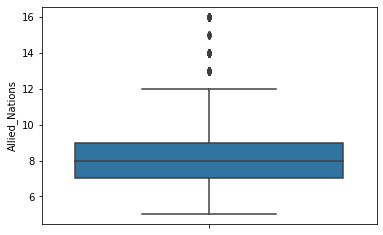

In [33]:
sns.boxplot(y='Allied_Nations', data=military)

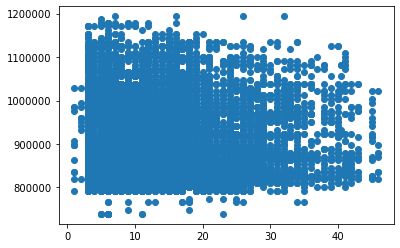

In [151]:
plt.scatter(x='Active_Threats', y='Troops_Mobilized(thousands)', data=military)

In [111]:
z = np.abs(stats.zscore(military))
print(z)

[[4.39305504 0.95138302 2.03362294 ... 0.59417138 0.47760938 0.36106634]
 [0.18173347 0.95138302 0.81735502 ... 0.44991085 1.72333024 1.6236738 ]
 [0.39011509 0.95138302 1.11723717 ... 0.87892108 0.47760938 1.13173567]
 ...
 [0.75358204 0.95138302 0.71553437 ... 0.26007772 0.47760938 1.56636294]
 [0.96196365 0.95138302 0.76086492 ... 0.87892108 0.76811148 0.36109637]
 [0.18173347 0.95138302 0.15552085 ... 0.59417138 0.76811148 0.86439187]]


In [112]:
military = military[(z < 3).all(axis=1)]

In [97]:
military.shape

(9383, 12)

In [69]:
Q1 = military.quantile(0.25)
Q3 = military.quantile(0.75)
IQR = Q3 - Q1
print(IQR)

Allied_Nations                       2.000000
Diplomatic_Meetings_Set              1.000000
Percent_Of_Forces_Mobilized          0.340000
Hostile_Nations                      1.000000
Active_Threats                      14.000000
Inactive_Threats                    41.000000
Citizen_Fear_Index                   0.161527
Closest_Threat_Distance(km)         20.140000
Aircraft_Carriers_Responding         0.000000
Troops_Mobilized(thousands)     140800.000000
DEFCON_Level                         1.000000
ID                                6251.750000
dtype: float64


In [70]:
military = military[~((military < (Q1 - 1.5 * IQR)) |(military > (Q3 + 1.5 * IQR))).any(axis=1)]
military.shape

(7574, 12)

In [113]:
military.columns.shape

(12,)

In [114]:
y=military.iloc[:,10].values

In [115]:
military["Nations_power"]=military["Allied_Nations"]-military["Hostile_Nations"]
# military["pranjal"]=military["Diplomatic_Meetings_Set"]/military["Troops_Mobilized(thousands)"]

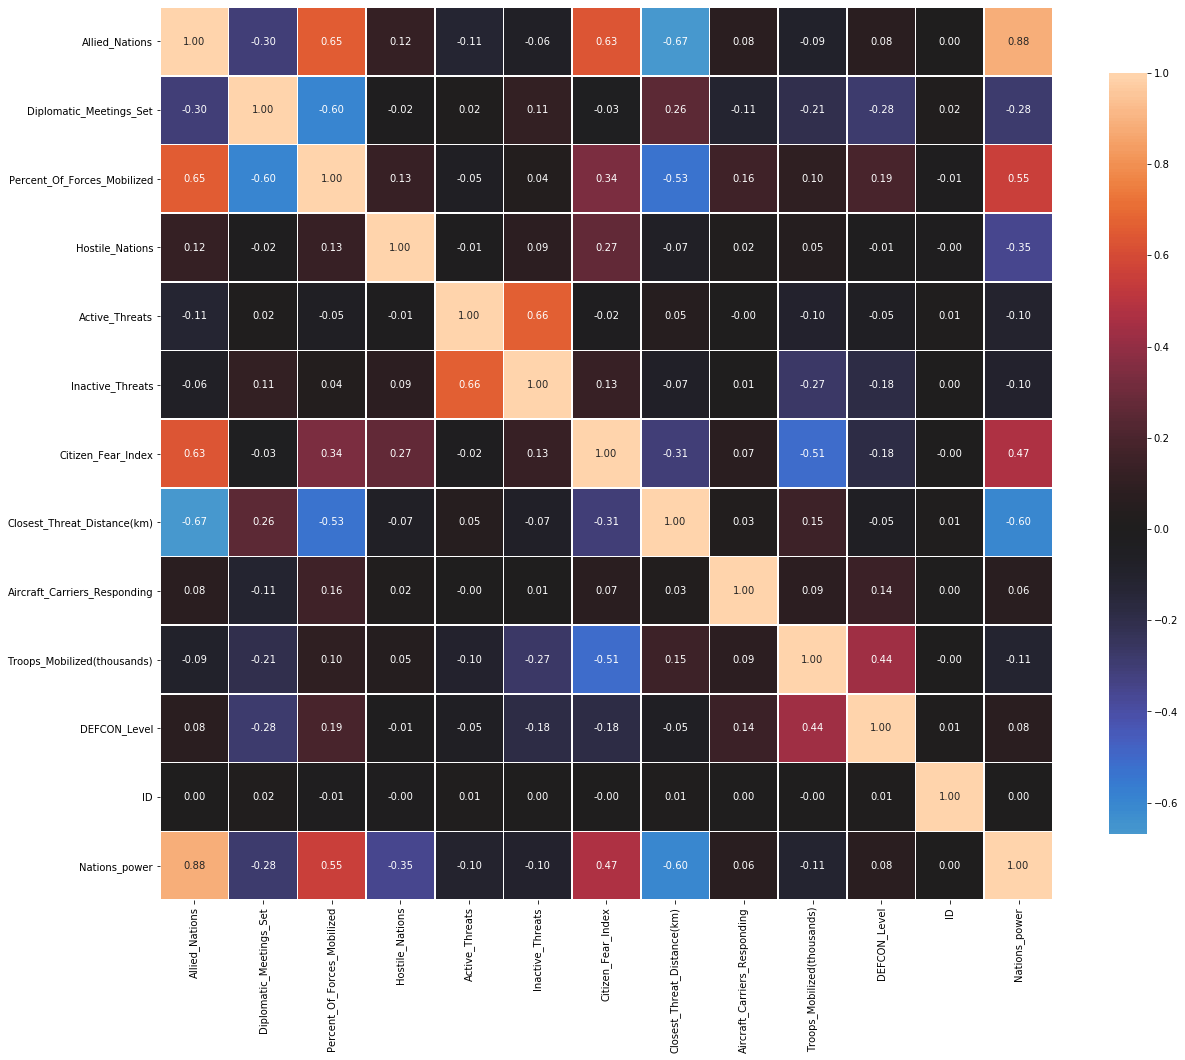

In [116]:
import seaborn as sns
def correlation_heatmap(train):
    correlations = military.corr()

    fig, ax = plt.subplots(figsize=(20,20))
    sns.heatmap(correlations, vmax=1.0, center=0, fmt='.2f',
                square=True, linewidths=.5, annot=True, cbar_kws={"shrink": .70})
    plt.show();
    
correlation_heatmap(military)

In [117]:
military=military.drop(["ID","DEFCON_Level","Allied_Nations","Hostile_Nations"],axis=1)
# "Diplomatic_Meetings_Set"
# "Allied_Nations","Hostile_Nations"
# "Active_Threats","Inactive_Threats"

In [118]:
military.columns.shape

(9,)

In [119]:
military.describe()

,Diplomatic_Meetings_Set,Percent_Of_Forces_Mobilized,Active_Threats,Inactive_Threats,Citizen_Fear_Index,Closest_Threat_Distance(km),Aircraft_Carriers_Responding,Troops_Mobilized(thousands),Nations_power
count,9383.000000,9383.000000,9383.000000,9383.000000,9383.000000,9383.000000,9383.000000,9.383000e+03,9383.000000
mean,0.527870,0.265022,14.959714,44.183737,0.483377,351.016012,0.886817,9.150589e+05,5.933603
std,0.500103,0.193228,9.211759,30.313522,0.122924,15.322913,0.316834,8.875936e+04,1.738673
min,0.000000,0.000000,1.000000,6.000000,0.104993,304.220000,0.000000,7.392000e+05,0.000000
25%,0.000000,0.090000,7.000000,21.000000,0.406021,340.260000,1.000000,8.360000e+05,5.000000
50%,1.000000,0.250000,13.000000,36.000000,0.483847,350.860000,1.000000,8.976000e+05,6.000000
75%,1.000000,0.420000,21.000000,59.000000,0.563142,360.400000,1.000000,9.768000e+05,7.000000
max,2.000000,0.780000,46.000000,148.000000,0.883260,397.500000,1.000000,1.193867e+06,11.000000


In [120]:
X=military.iloc[:,0:9].values


In [121]:
military.describe()

,Diplomatic_Meetings_Set,Percent_Of_Forces_Mobilized,Active_Threats,Inactive_Threats,Citizen_Fear_Index,Closest_Threat_Distance(km),Aircraft_Carriers_Responding,Troops_Mobilized(thousands),Nations_power
count,9383.000000,9383.000000,9383.000000,9383.000000,9383.000000,9383.000000,9383.000000,9.383000e+03,9383.000000
mean,0.527870,0.265022,14.959714,44.183737,0.483377,351.016012,0.886817,9.150589e+05,5.933603
std,0.500103,0.193228,9.211759,30.313522,0.122924,15.322913,0.316834,8.875936e+04,1.738673
min,0.000000,0.000000,1.000000,6.000000,0.104993,304.220000,0.000000,7.392000e+05,0.000000
25%,0.000000,0.090000,7.000000,21.000000,0.406021,340.260000,1.000000,8.360000e+05,5.000000
50%,1.000000,0.250000,13.000000,36.000000,0.483847,350.860000,1.000000,8.976000e+05,6.000000
75%,1.000000,0.420000,21.000000,59.000000,0.563142,360.400000,1.000000,9.768000e+05,7.000000
max,2.000000,0.780000,46.000000,148.000000,0.883260,397.500000,1.000000,1.193867e+06,11.000000


In [122]:
from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()

In [1357]:
X[:,2]=scaler.fit_transform(X[:,2])
X[:,3]=scaler.fit_transform(X[:,3])
X[:,5]=scaler.fit_transform(X[:,5])
X[:,7]=scaler.fit_transform(X[:,7])
X[:,8]=scaler.fit_transform(X[:,8])

ValueError: Expected 2D array, got 1D array instead:
array=[ 6. 38. 32. ... 25. 21. 15.].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [123]:
from sklearn.model_selection import train_test_split
X_train,X_test1,y_train,y_test1=train_test_split(X,y,test_size=0.2,random_state=2)

In [124]:
X_test1.shape

(1877, 9)

In [136]:
from lightgbm import LGBMClassifier
###best one (n_estimators=160,num_leaves=31,max_depth=14)
model=LGBMClassifier(n_estimators=160,num_leaves=31,max_depth=14,learning_rate=0.1)
model.fit(X_train,y_train)
# model.fit(X,y)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=14,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=160, n_jobs=-1, num_leaves=31, objective=None,
               random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

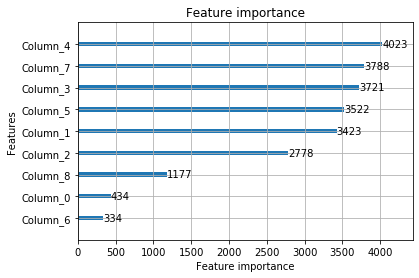

In [1130]:
import lightgbm
lightgbm.plot_importance(model)

In [852]:
est=np.arange(150,180,2)
lea=np.arange(20,50,5) 
dep=np.arange(5,15,1) 
from sklearn.model_selection import GridSearchCV
parameters ={'n_estimators':est,'num_leaves':lea,"max_depth":dep}

clf = GridSearchCV(model, parameters, n_jobs=1, cv=5, scoring='f1_weighted',verbose=10, refit=True)
clf.fit(X_train,y_train)
bestp=clf.best_score_
para=clf.best_params_
print(para,bestp)

Fitting 5 folds for each of 900 candidates, totalling 4500 fits
[CV] max_depth=5, n_estimators=150, num_leaves=20 ....................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  max_depth=5, n_estimators=150, num_leaves=20, score=0.572, total=   0.5s
[CV] max_depth=5, n_estimators=150, num_leaves=20 ....................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s remaining:    0.0s


[CV]  max_depth=5, n_estimators=150, num_leaves=20, score=0.597, total=   0.5s
[CV] max_depth=5, n_estimators=150, num_leaves=20 ....................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.8s remaining:    0.0s


[CV]  max_depth=5, n_estimators=150, num_leaves=20, score=0.578, total=   0.4s
[CV] max_depth=5, n_estimators=150, num_leaves=20 ....................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    1.3s remaining:    0.0s


[CV]  max_depth=5, n_estimators=150, num_leaves=20, score=0.582, total=   0.6s
[CV] max_depth=5, n_estimators=150, num_leaves=20 ....................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    1.8s remaining:    0.0s


[CV]  max_depth=5, n_estimators=150, num_leaves=20, score=0.581, total=   0.5s
[CV] max_depth=5, n_estimators=150, num_leaves=25 ....................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    2.3s remaining:    0.0s


[CV]  max_depth=5, n_estimators=150, num_leaves=25, score=0.582, total=   0.5s
[CV] max_depth=5, n_estimators=150, num_leaves=25 ....................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    2.8s remaining:    0.0s


[CV]  max_depth=5, n_estimators=150, num_leaves=25, score=0.600, total=   0.5s
[CV] max_depth=5, n_estimators=150, num_leaves=25 ....................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    3.3s remaining:    0.0s


[CV]  max_depth=5, n_estimators=150, num_leaves=25, score=0.576, total=   0.5s
[CV] max_depth=5, n_estimators=150, num_leaves=25 ....................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    3.8s remaining:    0.0s


[CV]  max_depth=5, n_estimators=150, num_leaves=25, score=0.584, total=   0.5s
[CV] max_depth=5, n_estimators=150, num_leaves=25 ....................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    4.3s remaining:    0.0s


[CV]  max_depth=5, n_estimators=150, num_leaves=25, score=0.595, total=   0.5s
[CV] max_depth=5, n_estimators=150, num_leaves=30 ....................
[CV]  max_depth=5, n_estimators=150, num_leaves=30, score=0.569, total=   0.5s
[CV] max_depth=5, n_estimators=150, num_leaves=30 ....................
[CV]  max_depth=5, n_estimators=150, num_leaves=30, score=0.596, total=   0.5s
[CV] max_depth=5, n_estimators=150, num_leaves=30 ....................
[CV]  max_depth=5, n_estimators=150, num_leaves=30, score=0.572, total=   0.5s
[CV] max_depth=5, n_estimators=150, num_leaves=30 ....................
[CV]  max_depth=5, n_estimators=150, num_leaves=30, score=0.581, total=   0.5s
[CV] max_depth=5, n_estimators=150, num_leaves=30 ....................
[CV]  max_depth=5, n_estimators=150, num_leaves=30, score=0.586, total=   0.5s
[CV] max_depth=5, n_estimators=150, num_leaves=35 ....................
[CV]  max_depth=5, n_estimators=150, num_leaves=35, score=0.581, total=   0.5s
[CV] max_depth=5, n_e

[CV]  max_depth=5, n_estimators=154, num_leaves=20, score=0.582, total=   0.6s
[CV] max_depth=5, n_estimators=154, num_leaves=25 ....................
[CV]  max_depth=5, n_estimators=154, num_leaves=25, score=0.582, total=   0.8s
[CV] max_depth=5, n_estimators=154, num_leaves=25 ....................
[CV]  max_depth=5, n_estimators=154, num_leaves=25, score=0.601, total=   0.8s
[CV] max_depth=5, n_estimators=154, num_leaves=25 ....................
[CV]  max_depth=5, n_estimators=154, num_leaves=25, score=0.575, total=   0.7s
[CV] max_depth=5, n_estimators=154, num_leaves=25 ....................
[CV]  max_depth=5, n_estimators=154, num_leaves=25, score=0.585, total=   0.6s
[CV] max_depth=5, n_estimators=154, num_leaves=25 ....................
[CV]  max_depth=5, n_estimators=154, num_leaves=25, score=0.593, total=   0.6s
[CV] max_depth=5, n_estimators=154, num_leaves=30 ....................
[CV]  max_depth=5, n_estimators=154, num_leaves=30, score=0.567, total=   0.8s
[CV] max_depth=5, n_e

[CV]  max_depth=5, n_estimators=156, num_leaves=45, score=0.584, total=   0.6s
[CV] max_depth=5, n_estimators=158, num_leaves=20 ....................
[CV]  max_depth=5, n_estimators=158, num_leaves=20, score=0.569, total=   0.6s
[CV] max_depth=5, n_estimators=158, num_leaves=20 ....................
[CV]  max_depth=5, n_estimators=158, num_leaves=20, score=0.595, total=   0.6s
[CV] max_depth=5, n_estimators=158, num_leaves=20 ....................
[CV]  max_depth=5, n_estimators=158, num_leaves=20, score=0.579, total=   0.6s
[CV] max_depth=5, n_estimators=158, num_leaves=20 ....................
[CV]  max_depth=5, n_estimators=158, num_leaves=20, score=0.580, total=   0.6s
[CV] max_depth=5, n_estimators=158, num_leaves=20 ....................
[CV]  max_depth=5, n_estimators=158, num_leaves=20, score=0.584, total=   0.6s
[CV] max_depth=5, n_estimators=158, num_leaves=25 ....................
[CV]  max_depth=5, n_estimators=158, num_leaves=25, score=0.580, total=   0.6s
[CV] max_depth=5, n_e

[CV]  max_depth=5, n_estimators=160, num_leaves=40, score=0.586, total=   0.7s
[CV] max_depth=5, n_estimators=160, num_leaves=45 ....................
[CV]  max_depth=5, n_estimators=160, num_leaves=45, score=0.576, total=   0.7s
[CV] max_depth=5, n_estimators=160, num_leaves=45 ....................
[CV]  max_depth=5, n_estimators=160, num_leaves=45, score=0.599, total=   0.7s
[CV] max_depth=5, n_estimators=160, num_leaves=45 ....................
[CV]  max_depth=5, n_estimators=160, num_leaves=45, score=0.564, total=   0.7s
[CV] max_depth=5, n_estimators=160, num_leaves=45 ....................
[CV]  max_depth=5, n_estimators=160, num_leaves=45, score=0.583, total=   0.7s
[CV] max_depth=5, n_estimators=160, num_leaves=45 ....................
[CV]  max_depth=5, n_estimators=160, num_leaves=45, score=0.586, total=   0.7s
[CV] max_depth=5, n_estimators=162, num_leaves=20 ....................
[CV]  max_depth=5, n_estimators=162, num_leaves=20, score=0.568, total=   0.6s
[CV] max_depth=5, n_e

[CV]  max_depth=5, n_estimators=164, num_leaves=35, score=0.587, total=   0.7s
[CV] max_depth=5, n_estimators=164, num_leaves=40 ....................
[CV]  max_depth=5, n_estimators=164, num_leaves=40, score=0.579, total=   0.7s
[CV] max_depth=5, n_estimators=164, num_leaves=40 ....................
[CV]  max_depth=5, n_estimators=164, num_leaves=40, score=0.600, total=   0.7s
[CV] max_depth=5, n_estimators=164, num_leaves=40 ....................
[CV]  max_depth=5, n_estimators=164, num_leaves=40, score=0.565, total=   0.7s
[CV] max_depth=5, n_estimators=164, num_leaves=40 ....................
[CV]  max_depth=5, n_estimators=164, num_leaves=40, score=0.584, total=   0.7s
[CV] max_depth=5, n_estimators=164, num_leaves=40 ....................
[CV]  max_depth=5, n_estimators=164, num_leaves=40, score=0.587, total=   0.7s
[CV] max_depth=5, n_estimators=164, num_leaves=45 ....................
[CV]  max_depth=5, n_estimators=164, num_leaves=45, score=0.579, total=   0.8s
[CV] max_depth=5, n_e

[CV]  max_depth=5, n_estimators=168, num_leaves=30, score=0.587, total=   0.8s
[CV] max_depth=5, n_estimators=168, num_leaves=35 ....................
[CV]  max_depth=5, n_estimators=168, num_leaves=35, score=0.579, total=   0.8s
[CV] max_depth=5, n_estimators=168, num_leaves=35 ....................
[CV]  max_depth=5, n_estimators=168, num_leaves=35, score=0.599, total=   0.7s
[CV] max_depth=5, n_estimators=168, num_leaves=35 ....................
[CV]  max_depth=5, n_estimators=168, num_leaves=35, score=0.566, total=   0.8s
[CV] max_depth=5, n_estimators=168, num_leaves=35 ....................
[CV]  max_depth=5, n_estimators=168, num_leaves=35, score=0.584, total=   0.8s
[CV] max_depth=5, n_estimators=168, num_leaves=35 ....................
[CV]  max_depth=5, n_estimators=168, num_leaves=35, score=0.584, total=   0.7s
[CV] max_depth=5, n_estimators=168, num_leaves=40 ....................
[CV]  max_depth=5, n_estimators=168, num_leaves=40, score=0.579, total=   0.8s
[CV] max_depth=5, n_e

[CV]  max_depth=5, n_estimators=172, num_leaves=25, score=0.586, total=   0.7s
[CV] max_depth=5, n_estimators=172, num_leaves=30 ....................
[CV]  max_depth=5, n_estimators=172, num_leaves=30, score=0.576, total=   0.7s
[CV] max_depth=5, n_estimators=172, num_leaves=30 ....................
[CV]  max_depth=5, n_estimators=172, num_leaves=30, score=0.601, total=   0.7s
[CV] max_depth=5, n_estimators=172, num_leaves=30 ....................
[CV]  max_depth=5, n_estimators=172, num_leaves=30, score=0.573, total=   0.7s
[CV] max_depth=5, n_estimators=172, num_leaves=30 ....................
[CV]  max_depth=5, n_estimators=172, num_leaves=30, score=0.586, total=   0.7s
[CV] max_depth=5, n_estimators=172, num_leaves=30 ....................
[CV]  max_depth=5, n_estimators=172, num_leaves=30, score=0.588, total=   0.7s
[CV] max_depth=5, n_estimators=172, num_leaves=35 ....................
[CV]  max_depth=5, n_estimators=172, num_leaves=35, score=0.579, total=   0.7s
[CV] max_depth=5, n_e

[CV]  max_depth=5, n_estimators=176, num_leaves=20, score=0.580, total=   0.7s
[CV] max_depth=5, n_estimators=176, num_leaves=25 ....................
[CV]  max_depth=5, n_estimators=176, num_leaves=25, score=0.588, total=   0.7s
[CV] max_depth=5, n_estimators=176, num_leaves=25 ....................
[CV]  max_depth=5, n_estimators=176, num_leaves=25, score=0.601, total=   0.7s
[CV] max_depth=5, n_estimators=176, num_leaves=25 ....................
[CV]  max_depth=5, n_estimators=176, num_leaves=25, score=0.575, total=   0.7s
[CV] max_depth=5, n_estimators=176, num_leaves=25 ....................
[CV]  max_depth=5, n_estimators=176, num_leaves=25, score=0.584, total=   0.7s
[CV] max_depth=5, n_estimators=176, num_leaves=25 ....................
[CV]  max_depth=5, n_estimators=176, num_leaves=25, score=0.586, total=   0.7s
[CV] max_depth=5, n_estimators=176, num_leaves=30 ....................
[CV]  max_depth=5, n_estimators=176, num_leaves=30, score=0.575, total=   0.7s
[CV] max_depth=5, n_e

[CV]  max_depth=5, n_estimators=178, num_leaves=45, score=0.587, total=   0.7s
[CV] max_depth=6, n_estimators=150, num_leaves=20 ....................
[CV]  max_depth=6, n_estimators=150, num_leaves=20, score=0.577, total=   0.6s
[CV] max_depth=6, n_estimators=150, num_leaves=20 ....................
[CV]  max_depth=6, n_estimators=150, num_leaves=20, score=0.599, total=   0.6s
[CV] max_depth=6, n_estimators=150, num_leaves=20 ....................
[CV]  max_depth=6, n_estimators=150, num_leaves=20, score=0.571, total=   0.6s
[CV] max_depth=6, n_estimators=150, num_leaves=20 ....................
[CV]  max_depth=6, n_estimators=150, num_leaves=20, score=0.581, total=   0.6s
[CV] max_depth=6, n_estimators=150, num_leaves=20 ....................
[CV]  max_depth=6, n_estimators=150, num_leaves=20, score=0.592, total=   0.6s
[CV] max_depth=6, n_estimators=150, num_leaves=25 ....................
[CV]  max_depth=6, n_estimators=150, num_leaves=25, score=0.578, total=   0.7s
[CV] max_depth=6, n_e

[CV]  max_depth=6, n_estimators=152, num_leaves=40, score=0.589, total=   0.8s
[CV] max_depth=6, n_estimators=152, num_leaves=45 ....................
[CV]  max_depth=6, n_estimators=152, num_leaves=45, score=0.589, total=   1.0s
[CV] max_depth=6, n_estimators=152, num_leaves=45 ....................
[CV]  max_depth=6, n_estimators=152, num_leaves=45, score=0.598, total=   0.9s
[CV] max_depth=6, n_estimators=152, num_leaves=45 ....................
[CV]  max_depth=6, n_estimators=152, num_leaves=45, score=0.580, total=   0.8s
[CV] max_depth=6, n_estimators=152, num_leaves=45 ....................
[CV]  max_depth=6, n_estimators=152, num_leaves=45, score=0.604, total=   0.9s
[CV] max_depth=6, n_estimators=152, num_leaves=45 ....................
[CV]  max_depth=6, n_estimators=152, num_leaves=45, score=0.586, total=   0.8s
[CV] max_depth=6, n_estimators=154, num_leaves=20 ....................
[CV]  max_depth=6, n_estimators=154, num_leaves=20, score=0.576, total=   0.6s
[CV] max_depth=6, n_e

[CV]  max_depth=6, n_estimators=156, num_leaves=35, score=0.588, total=   0.8s
[CV] max_depth=6, n_estimators=156, num_leaves=40 ....................
[CV]  max_depth=6, n_estimators=156, num_leaves=40, score=0.578, total=   0.8s
[CV] max_depth=6, n_estimators=156, num_leaves=40 ....................
[CV]  max_depth=6, n_estimators=156, num_leaves=40, score=0.603, total=   0.9s
[CV] max_depth=6, n_estimators=156, num_leaves=40 ....................
[CV]  max_depth=6, n_estimators=156, num_leaves=40, score=0.576, total=   0.8s
[CV] max_depth=6, n_estimators=156, num_leaves=40 ....................
[CV]  max_depth=6, n_estimators=156, num_leaves=40, score=0.600, total=   0.9s
[CV] max_depth=6, n_estimators=156, num_leaves=40 ....................
[CV]  max_depth=6, n_estimators=156, num_leaves=40, score=0.595, total=   0.8s
[CV] max_depth=6, n_estimators=156, num_leaves=45 ....................
[CV]  max_depth=6, n_estimators=156, num_leaves=45, score=0.591, total=   0.9s
[CV] max_depth=6, n_e

[CV]  max_depth=6, n_estimators=160, num_leaves=30, score=0.595, total=   0.8s
[CV] max_depth=6, n_estimators=160, num_leaves=35 ....................
[CV]  max_depth=6, n_estimators=160, num_leaves=35, score=0.580, total=   0.8s
[CV] max_depth=6, n_estimators=160, num_leaves=35 ....................
[CV]  max_depth=6, n_estimators=160, num_leaves=35, score=0.607, total=   0.8s
[CV] max_depth=6, n_estimators=160, num_leaves=35 ....................
[CV]  max_depth=6, n_estimators=160, num_leaves=35, score=0.580, total=   0.8s
[CV] max_depth=6, n_estimators=160, num_leaves=35 ....................
[CV]  max_depth=6, n_estimators=160, num_leaves=35, score=0.600, total=   0.8s
[CV] max_depth=6, n_estimators=160, num_leaves=35 ....................
[CV]  max_depth=6, n_estimators=160, num_leaves=35, score=0.590, total=   0.8s
[CV] max_depth=6, n_estimators=160, num_leaves=40 ....................
[CV]  max_depth=6, n_estimators=160, num_leaves=40, score=0.577, total=   0.9s
[CV] max_depth=6, n_e

[CV]  max_depth=6, n_estimators=164, num_leaves=25, score=0.593, total=   0.7s
[CV] max_depth=6, n_estimators=164, num_leaves=30 ....................
[CV]  max_depth=6, n_estimators=164, num_leaves=30, score=0.583, total=   0.8s
[CV] max_depth=6, n_estimators=164, num_leaves=30 ....................
[CV]  max_depth=6, n_estimators=164, num_leaves=30, score=0.605, total=   0.8s
[CV] max_depth=6, n_estimators=164, num_leaves=30 ....................
[CV]  max_depth=6, n_estimators=164, num_leaves=30, score=0.587, total=   0.8s
[CV] max_depth=6, n_estimators=164, num_leaves=30 ....................
[CV]  max_depth=6, n_estimators=164, num_leaves=30, score=0.601, total=   0.8s
[CV] max_depth=6, n_estimators=164, num_leaves=30 ....................
[CV]  max_depth=6, n_estimators=164, num_leaves=30, score=0.597, total=   0.8s
[CV] max_depth=6, n_estimators=164, num_leaves=35 ....................
[CV]  max_depth=6, n_estimators=164, num_leaves=35, score=0.579, total=   0.8s
[CV] max_depth=6, n_e

[CV]  max_depth=6, n_estimators=168, num_leaves=20, score=0.595, total=   0.7s
[CV] max_depth=6, n_estimators=168, num_leaves=25 ....................
[CV]  max_depth=6, n_estimators=168, num_leaves=25, score=0.579, total=   0.8s
[CV] max_depth=6, n_estimators=168, num_leaves=25 ....................
[CV]  max_depth=6, n_estimators=168, num_leaves=25, score=0.605, total=   0.8s
[CV] max_depth=6, n_estimators=168, num_leaves=25 ....................
[CV]  max_depth=6, n_estimators=168, num_leaves=25, score=0.570, total=   0.8s
[CV] max_depth=6, n_estimators=168, num_leaves=25 ....................
[CV]  max_depth=6, n_estimators=168, num_leaves=25, score=0.592, total=   0.8s
[CV] max_depth=6, n_estimators=168, num_leaves=25 ....................
[CV]  max_depth=6, n_estimators=168, num_leaves=25, score=0.594, total=   0.8s
[CV] max_depth=6, n_estimators=168, num_leaves=30 ....................
[CV]  max_depth=6, n_estimators=168, num_leaves=30, score=0.583, total=   0.8s
[CV] max_depth=6, n_e

[CV]  max_depth=6, n_estimators=170, num_leaves=45, score=0.584, total=   1.1s
[CV] max_depth=6, n_estimators=172, num_leaves=20 ....................
[CV]  max_depth=6, n_estimators=172, num_leaves=20, score=0.579, total=   0.7s
[CV] max_depth=6, n_estimators=172, num_leaves=20 ....................
[CV]  max_depth=6, n_estimators=172, num_leaves=20, score=0.601, total=   0.7s
[CV] max_depth=6, n_estimators=172, num_leaves=20 ....................
[CV]  max_depth=6, n_estimators=172, num_leaves=20, score=0.570, total=   0.7s
[CV] max_depth=6, n_estimators=172, num_leaves=20 ....................
[CV]  max_depth=6, n_estimators=172, num_leaves=20, score=0.586, total=   0.7s
[CV] max_depth=6, n_estimators=172, num_leaves=20 ....................
[CV]  max_depth=6, n_estimators=172, num_leaves=20, score=0.598, total=   0.7s
[CV] max_depth=6, n_estimators=172, num_leaves=25 ....................
[CV]  max_depth=6, n_estimators=172, num_leaves=25, score=0.579, total=   0.8s
[CV] max_depth=6, n_e

[CV]  max_depth=6, n_estimators=174, num_leaves=40, score=0.590, total=   1.0s
[CV] max_depth=6, n_estimators=174, num_leaves=45 ....................
[CV]  max_depth=6, n_estimators=174, num_leaves=45, score=0.586, total=   1.0s
[CV] max_depth=6, n_estimators=174, num_leaves=45 ....................
[CV]  max_depth=6, n_estimators=174, num_leaves=45, score=0.602, total=   1.0s
[CV] max_depth=6, n_estimators=174, num_leaves=45 ....................
[CV]  max_depth=6, n_estimators=174, num_leaves=45, score=0.579, total=   1.0s
[CV] max_depth=6, n_estimators=174, num_leaves=45 ....................
[CV]  max_depth=6, n_estimators=174, num_leaves=45, score=0.604, total=   1.0s
[CV] max_depth=6, n_estimators=174, num_leaves=45 ....................
[CV]  max_depth=6, n_estimators=174, num_leaves=45, score=0.589, total=   0.9s
[CV] max_depth=6, n_estimators=176, num_leaves=20 ....................
[CV]  max_depth=6, n_estimators=176, num_leaves=20, score=0.578, total=   0.7s
[CV] max_depth=6, n_e

[CV]  max_depth=6, n_estimators=178, num_leaves=35, score=0.592, total=   0.9s
[CV] max_depth=6, n_estimators=178, num_leaves=40 ....................
[CV]  max_depth=6, n_estimators=178, num_leaves=40, score=0.577, total=   0.9s
[CV] max_depth=6, n_estimators=178, num_leaves=40 ....................
[CV]  max_depth=6, n_estimators=178, num_leaves=40, score=0.604, total=   1.0s
[CV] max_depth=6, n_estimators=178, num_leaves=40 ....................
[CV]  max_depth=6, n_estimators=178, num_leaves=40, score=0.578, total=   1.0s
[CV] max_depth=6, n_estimators=178, num_leaves=40 ....................
[CV]  max_depth=6, n_estimators=178, num_leaves=40, score=0.602, total=   1.0s
[CV] max_depth=6, n_estimators=178, num_leaves=40 ....................
[CV]  max_depth=6, n_estimators=178, num_leaves=40, score=0.589, total=   1.0s
[CV] max_depth=6, n_estimators=178, num_leaves=45 ....................
[CV]  max_depth=6, n_estimators=178, num_leaves=45, score=0.585, total=   1.0s
[CV] max_depth=6, n_e

[CV]  max_depth=7, n_estimators=152, num_leaves=30, score=0.601, total=   0.8s
[CV] max_depth=7, n_estimators=152, num_leaves=35 ....................
[CV]  max_depth=7, n_estimators=152, num_leaves=35, score=0.587, total=   0.9s
[CV] max_depth=7, n_estimators=152, num_leaves=35 ....................
[CV]  max_depth=7, n_estimators=152, num_leaves=35, score=0.606, total=   0.9s
[CV] max_depth=7, n_estimators=152, num_leaves=35 ....................
[CV]  max_depth=7, n_estimators=152, num_leaves=35, score=0.586, total=   0.9s
[CV] max_depth=7, n_estimators=152, num_leaves=35 ....................
[CV]  max_depth=7, n_estimators=152, num_leaves=35, score=0.604, total=   0.9s
[CV] max_depth=7, n_estimators=152, num_leaves=35 ....................
[CV]  max_depth=7, n_estimators=152, num_leaves=35, score=0.595, total=   0.9s
[CV] max_depth=7, n_estimators=152, num_leaves=40 ....................
[CV]  max_depth=7, n_estimators=152, num_leaves=40, score=0.604, total=   0.9s
[CV] max_depth=7, n_e

[CV]  max_depth=7, n_estimators=156, num_leaves=25, score=0.593, total=   0.7s
[CV] max_depth=7, n_estimators=156, num_leaves=30 ....................
[CV]  max_depth=7, n_estimators=156, num_leaves=30, score=0.587, total=   0.8s
[CV] max_depth=7, n_estimators=156, num_leaves=30 ....................
[CV]  max_depth=7, n_estimators=156, num_leaves=30, score=0.609, total=   0.8s
[CV] max_depth=7, n_estimators=156, num_leaves=30 ....................
[CV]  max_depth=7, n_estimators=156, num_leaves=30, score=0.588, total=   0.9s
[CV] max_depth=7, n_estimators=156, num_leaves=30 ....................
[CV]  max_depth=7, n_estimators=156, num_leaves=30, score=0.604, total=   0.8s
[CV] max_depth=7, n_estimators=156, num_leaves=30 ....................
[CV]  max_depth=7, n_estimators=156, num_leaves=30, score=0.602, total=   0.9s
[CV] max_depth=7, n_estimators=156, num_leaves=35 ....................
[CV]  max_depth=7, n_estimators=156, num_leaves=35, score=0.590, total=   0.9s
[CV] max_depth=7, n_e

[CV]  max_depth=7, n_estimators=160, num_leaves=20, score=0.590, total=   0.8s
[CV] max_depth=7, n_estimators=160, num_leaves=25 ....................
[CV]  max_depth=7, n_estimators=160, num_leaves=25, score=0.589, total=   1.0s
[CV] max_depth=7, n_estimators=160, num_leaves=25 ....................
[CV]  max_depth=7, n_estimators=160, num_leaves=25, score=0.601, total=   1.0s
[CV] max_depth=7, n_estimators=160, num_leaves=25 ....................
[CV]  max_depth=7, n_estimators=160, num_leaves=25, score=0.580, total=   0.9s
[CV] max_depth=7, n_estimators=160, num_leaves=25 ....................
[CV]  max_depth=7, n_estimators=160, num_leaves=25, score=0.599, total=   0.8s
[CV] max_depth=7, n_estimators=160, num_leaves=25 ....................
[CV]  max_depth=7, n_estimators=160, num_leaves=25, score=0.592, total=   0.8s
[CV] max_depth=7, n_estimators=160, num_leaves=30 ....................
[CV]  max_depth=7, n_estimators=160, num_leaves=30, score=0.587, total=   0.9s
[CV] max_depth=7, n_e

[CV]  max_depth=7, n_estimators=162, num_leaves=45, score=0.596, total=   1.1s
[CV] max_depth=7, n_estimators=164, num_leaves=20 ....................
[CV]  max_depth=7, n_estimators=164, num_leaves=20, score=0.578, total=   0.7s
[CV] max_depth=7, n_estimators=164, num_leaves=20 ....................
[CV]  max_depth=7, n_estimators=164, num_leaves=20, score=0.606, total=   0.7s
[CV] max_depth=7, n_estimators=164, num_leaves=20 ....................
[CV]  max_depth=7, n_estimators=164, num_leaves=20, score=0.578, total=   0.7s
[CV] max_depth=7, n_estimators=164, num_leaves=20 ....................
[CV]  max_depth=7, n_estimators=164, num_leaves=20, score=0.598, total=   0.7s
[CV] max_depth=7, n_estimators=164, num_leaves=20 ....................
[CV]  max_depth=7, n_estimators=164, num_leaves=20, score=0.587, total=   0.7s
[CV] max_depth=7, n_estimators=164, num_leaves=25 ....................
[CV]  max_depth=7, n_estimators=164, num_leaves=25, score=0.589, total=   0.8s
[CV] max_depth=7, n_e

[CV]  max_depth=7, n_estimators=166, num_leaves=40, score=0.591, total=   1.0s
[CV] max_depth=7, n_estimators=166, num_leaves=45 ....................
[CV]  max_depth=7, n_estimators=166, num_leaves=45, score=0.589, total=   1.1s
[CV] max_depth=7, n_estimators=166, num_leaves=45 ....................
[CV]  max_depth=7, n_estimators=166, num_leaves=45, score=0.604, total=   1.1s
[CV] max_depth=7, n_estimators=166, num_leaves=45 ....................
[CV]  max_depth=7, n_estimators=166, num_leaves=45, score=0.581, total=   1.1s
[CV] max_depth=7, n_estimators=166, num_leaves=45 ....................
[CV]  max_depth=7, n_estimators=166, num_leaves=45, score=0.610, total=   1.1s
[CV] max_depth=7, n_estimators=166, num_leaves=45 ....................
[CV]  max_depth=7, n_estimators=166, num_leaves=45, score=0.594, total=   1.1s
[CV] max_depth=7, n_estimators=168, num_leaves=20 ....................
[CV]  max_depth=7, n_estimators=168, num_leaves=20, score=0.578, total=   0.7s
[CV] max_depth=7, n_e

[CV]  max_depth=7, n_estimators=170, num_leaves=35, score=0.591, total=   1.0s
[CV] max_depth=7, n_estimators=170, num_leaves=40 ....................
[CV]  max_depth=7, n_estimators=170, num_leaves=40, score=0.601, total=   1.0s
[CV] max_depth=7, n_estimators=170, num_leaves=40 ....................
[CV]  max_depth=7, n_estimators=170, num_leaves=40, score=0.602, total=   1.0s
[CV] max_depth=7, n_estimators=170, num_leaves=40 ....................
[CV]  max_depth=7, n_estimators=170, num_leaves=40, score=0.580, total=   1.0s
[CV] max_depth=7, n_estimators=170, num_leaves=40 ....................
[CV]  max_depth=7, n_estimators=170, num_leaves=40, score=0.613, total=   1.1s
[CV] max_depth=7, n_estimators=170, num_leaves=40 ....................
[CV]  max_depth=7, n_estimators=170, num_leaves=40, score=0.590, total=   1.1s
[CV] max_depth=7, n_estimators=170, num_leaves=45 ....................
[CV]  max_depth=7, n_estimators=170, num_leaves=45, score=0.588, total=   1.1s
[CV] max_depth=7, n_e

[CV]  max_depth=7, n_estimators=174, num_leaves=30, score=0.598, total=   0.9s
[CV] max_depth=7, n_estimators=174, num_leaves=35 ....................
[CV]  max_depth=7, n_estimators=174, num_leaves=35, score=0.593, total=   1.0s
[CV] max_depth=7, n_estimators=174, num_leaves=35 ....................
[CV]  max_depth=7, n_estimators=174, num_leaves=35, score=0.602, total=   1.0s
[CV] max_depth=7, n_estimators=174, num_leaves=35 ....................
[CV]  max_depth=7, n_estimators=174, num_leaves=35, score=0.580, total=   1.0s
[CV] max_depth=7, n_estimators=174, num_leaves=35 ....................
[CV]  max_depth=7, n_estimators=174, num_leaves=35, score=0.602, total=   1.0s
[CV] max_depth=7, n_estimators=174, num_leaves=35 ....................
[CV]  max_depth=7, n_estimators=174, num_leaves=35, score=0.590, total=   1.0s
[CV] max_depth=7, n_estimators=174, num_leaves=40 ....................
[CV]  max_depth=7, n_estimators=174, num_leaves=40, score=0.599, total=   1.0s
[CV] max_depth=7, n_e

[CV]  max_depth=7, n_estimators=178, num_leaves=25, score=0.593, total=   0.9s
[CV] max_depth=7, n_estimators=178, num_leaves=30 ....................
[CV]  max_depth=7, n_estimators=178, num_leaves=30, score=0.585, total=   1.0s
[CV] max_depth=7, n_estimators=178, num_leaves=30 ....................
[CV]  max_depth=7, n_estimators=178, num_leaves=30, score=0.604, total=   1.0s
[CV] max_depth=7, n_estimators=178, num_leaves=30 ....................
[CV]  max_depth=7, n_estimators=178, num_leaves=30, score=0.586, total=   1.0s
[CV] max_depth=7, n_estimators=178, num_leaves=30 ....................
[CV]  max_depth=7, n_estimators=178, num_leaves=30, score=0.597, total=   1.0s
[CV] max_depth=7, n_estimators=178, num_leaves=30 ....................
[CV]  max_depth=7, n_estimators=178, num_leaves=30, score=0.599, total=   1.0s
[CV] max_depth=7, n_estimators=178, num_leaves=35 ....................
[CV]  max_depth=7, n_estimators=178, num_leaves=35, score=0.589, total=   1.0s
[CV] max_depth=7, n_e

[CV]  max_depth=8, n_estimators=152, num_leaves=20, score=0.601, total=   0.7s
[CV] max_depth=8, n_estimators=152, num_leaves=25 ....................
[CV]  max_depth=8, n_estimators=152, num_leaves=25, score=0.592, total=   0.8s
[CV] max_depth=8, n_estimators=152, num_leaves=25 ....................
[CV]  max_depth=8, n_estimators=152, num_leaves=25, score=0.612, total=   0.8s
[CV] max_depth=8, n_estimators=152, num_leaves=25 ....................
[CV]  max_depth=8, n_estimators=152, num_leaves=25, score=0.585, total=   0.8s
[CV] max_depth=8, n_estimators=152, num_leaves=25 ....................
[CV]  max_depth=8, n_estimators=152, num_leaves=25, score=0.595, total=   0.8s
[CV] max_depth=8, n_estimators=152, num_leaves=25 ....................
[CV]  max_depth=8, n_estimators=152, num_leaves=25, score=0.599, total=   0.8s
[CV] max_depth=8, n_estimators=152, num_leaves=30 ....................
[CV]  max_depth=8, n_estimators=152, num_leaves=30, score=0.592, total=   0.9s
[CV] max_depth=8, n_e

[CV]  max_depth=8, n_estimators=154, num_leaves=45, score=0.594, total=   1.2s
[CV] max_depth=8, n_estimators=156, num_leaves=20 ....................
[CV]  max_depth=8, n_estimators=156, num_leaves=20, score=0.579, total=   0.7s
[CV] max_depth=8, n_estimators=156, num_leaves=20 ....................
[CV]  max_depth=8, n_estimators=156, num_leaves=20, score=0.606, total=   0.8s
[CV] max_depth=8, n_estimators=156, num_leaves=20 ....................
[CV]  max_depth=8, n_estimators=156, num_leaves=20, score=0.582, total=   0.7s
[CV] max_depth=8, n_estimators=156, num_leaves=20 ....................
[CV]  max_depth=8, n_estimators=156, num_leaves=20, score=0.584, total=   0.7s
[CV] max_depth=8, n_estimators=156, num_leaves=20 ....................
[CV]  max_depth=8, n_estimators=156, num_leaves=20, score=0.601, total=   0.7s
[CV] max_depth=8, n_estimators=156, num_leaves=25 ....................
[CV]  max_depth=8, n_estimators=156, num_leaves=25, score=0.592, total=   0.8s
[CV] max_depth=8, n_e

[CV]  max_depth=8, n_estimators=158, num_leaves=40, score=0.587, total=   1.1s
[CV] max_depth=8, n_estimators=158, num_leaves=45 ....................
[CV]  max_depth=8, n_estimators=158, num_leaves=45, score=0.591, total=   1.2s
[CV] max_depth=8, n_estimators=158, num_leaves=45 ....................
[CV]  max_depth=8, n_estimators=158, num_leaves=45, score=0.613, total=   1.2s
[CV] max_depth=8, n_estimators=158, num_leaves=45 ....................
[CV]  max_depth=8, n_estimators=158, num_leaves=45, score=0.586, total=   1.2s
[CV] max_depth=8, n_estimators=158, num_leaves=45 ....................
[CV]  max_depth=8, n_estimators=158, num_leaves=45, score=0.604, total=   1.1s
[CV] max_depth=8, n_estimators=158, num_leaves=45 ....................
[CV]  max_depth=8, n_estimators=158, num_leaves=45, score=0.597, total=   1.1s
[CV] max_depth=8, n_estimators=160, num_leaves=20 ....................
[CV]  max_depth=8, n_estimators=160, num_leaves=20, score=0.578, total=   0.7s
[CV] max_depth=8, n_e

[CV]  max_depth=8, n_estimators=162, num_leaves=35, score=0.597, total=   1.0s
[CV] max_depth=8, n_estimators=162, num_leaves=40 ....................
[CV]  max_depth=8, n_estimators=162, num_leaves=40, score=0.595, total=   1.1s
[CV] max_depth=8, n_estimators=162, num_leaves=40 ....................
[CV]  max_depth=8, n_estimators=162, num_leaves=40, score=0.610, total=   1.1s
[CV] max_depth=8, n_estimators=162, num_leaves=40 ....................
[CV]  max_depth=8, n_estimators=162, num_leaves=40, score=0.592, total=   1.1s
[CV] max_depth=8, n_estimators=162, num_leaves=40 ....................
[CV]  max_depth=8, n_estimators=162, num_leaves=40, score=0.597, total=   1.1s
[CV] max_depth=8, n_estimators=162, num_leaves=40 ....................
[CV]  max_depth=8, n_estimators=162, num_leaves=40, score=0.591, total=   1.1s
[CV] max_depth=8, n_estimators=162, num_leaves=45 ....................
[CV]  max_depth=8, n_estimators=162, num_leaves=45, score=0.592, total=   1.2s
[CV] max_depth=8, n_e

[CV]  max_depth=8, n_estimators=166, num_leaves=30, score=0.589, total=   0.9s
[CV] max_depth=8, n_estimators=166, num_leaves=35 ....................
[CV]  max_depth=8, n_estimators=166, num_leaves=35, score=0.586, total=   1.0s
[CV] max_depth=8, n_estimators=166, num_leaves=35 ....................
[CV]  max_depth=8, n_estimators=166, num_leaves=35, score=0.609, total=   1.0s
[CV] max_depth=8, n_estimators=166, num_leaves=35 ....................
[CV]  max_depth=8, n_estimators=166, num_leaves=35, score=0.588, total=   1.0s
[CV] max_depth=8, n_estimators=166, num_leaves=35 ....................
[CV]  max_depth=8, n_estimators=166, num_leaves=35, score=0.595, total=   1.0s
[CV] max_depth=8, n_estimators=166, num_leaves=35 ....................
[CV]  max_depth=8, n_estimators=166, num_leaves=35, score=0.596, total=   1.1s
[CV] max_depth=8, n_estimators=166, num_leaves=40 ....................
[CV]  max_depth=8, n_estimators=166, num_leaves=40, score=0.596, total=   1.2s
[CV] max_depth=8, n_e

[CV]  max_depth=8, n_estimators=170, num_leaves=25, score=0.602, total=   0.9s
[CV] max_depth=8, n_estimators=170, num_leaves=30 ....................
[CV]  max_depth=8, n_estimators=170, num_leaves=30, score=0.591, total=   1.0s
[CV] max_depth=8, n_estimators=170, num_leaves=30 ....................
[CV]  max_depth=8, n_estimators=170, num_leaves=30, score=0.609, total=   1.0s
[CV] max_depth=8, n_estimators=170, num_leaves=30 ....................
[CV]  max_depth=8, n_estimators=170, num_leaves=30, score=0.583, total=   1.0s
[CV] max_depth=8, n_estimators=170, num_leaves=30 ....................
[CV]  max_depth=8, n_estimators=170, num_leaves=30, score=0.603, total=   1.0s
[CV] max_depth=8, n_estimators=170, num_leaves=30 ....................
[CV]  max_depth=8, n_estimators=170, num_leaves=30, score=0.591, total=   1.0s
[CV] max_depth=8, n_estimators=170, num_leaves=35 ....................
[CV]  max_depth=8, n_estimators=170, num_leaves=35, score=0.585, total=   1.0s
[CV] max_depth=8, n_e

[CV]  max_depth=8, n_estimators=174, num_leaves=20, score=0.597, total=   0.7s
[CV] max_depth=8, n_estimators=174, num_leaves=25 ....................
[CV]  max_depth=8, n_estimators=174, num_leaves=25, score=0.588, total=   0.9s
[CV] max_depth=8, n_estimators=174, num_leaves=25 ....................
[CV]  max_depth=8, n_estimators=174, num_leaves=25, score=0.607, total=   0.9s
[CV] max_depth=8, n_estimators=174, num_leaves=25 ....................
[CV]  max_depth=8, n_estimators=174, num_leaves=25, score=0.579, total=   0.9s
[CV] max_depth=8, n_estimators=174, num_leaves=25 ....................
[CV]  max_depth=8, n_estimators=174, num_leaves=25, score=0.598, total=   0.9s
[CV] max_depth=8, n_estimators=174, num_leaves=25 ....................
[CV]  max_depth=8, n_estimators=174, num_leaves=25, score=0.599, total=   0.8s
[CV] max_depth=8, n_estimators=174, num_leaves=30 ....................
[CV]  max_depth=8, n_estimators=174, num_leaves=30, score=0.589, total=   1.0s
[CV] max_depth=8, n_e

[CV]  max_depth=8, n_estimators=176, num_leaves=45, score=0.597, total=   1.5s
[CV] max_depth=8, n_estimators=178, num_leaves=20 ....................
[CV]  max_depth=8, n_estimators=178, num_leaves=20, score=0.581, total=   0.8s
[CV] max_depth=8, n_estimators=178, num_leaves=20 ....................
[CV]  max_depth=8, n_estimators=178, num_leaves=20, score=0.603, total=   0.8s
[CV] max_depth=8, n_estimators=178, num_leaves=20 ....................
[CV]  max_depth=8, n_estimators=178, num_leaves=20, score=0.582, total=   0.8s
[CV] max_depth=8, n_estimators=178, num_leaves=20 ....................
[CV]  max_depth=8, n_estimators=178, num_leaves=20, score=0.591, total=   0.8s
[CV] max_depth=8, n_estimators=178, num_leaves=20 ....................
[CV]  max_depth=8, n_estimators=178, num_leaves=20, score=0.597, total=   0.7s
[CV] max_depth=8, n_estimators=178, num_leaves=25 ....................
[CV]  max_depth=8, n_estimators=178, num_leaves=25, score=0.588, total=   0.9s
[CV] max_depth=8, n_e

[CV]  max_depth=9, n_estimators=150, num_leaves=40, score=0.599, total=   1.1s
[CV] max_depth=9, n_estimators=150, num_leaves=45 ....................
[CV]  max_depth=9, n_estimators=150, num_leaves=45, score=0.586, total=   1.1s
[CV] max_depth=9, n_estimators=150, num_leaves=45 ....................
[CV]  max_depth=9, n_estimators=150, num_leaves=45, score=0.618, total=   1.1s
[CV] max_depth=9, n_estimators=150, num_leaves=45 ....................
[CV]  max_depth=9, n_estimators=150, num_leaves=45, score=0.591, total=   1.2s
[CV] max_depth=9, n_estimators=150, num_leaves=45 ....................
[CV]  max_depth=9, n_estimators=150, num_leaves=45, score=0.609, total=   1.2s
[CV] max_depth=9, n_estimators=150, num_leaves=45 ....................
[CV]  max_depth=9, n_estimators=150, num_leaves=45, score=0.590, total=   1.1s
[CV] max_depth=9, n_estimators=152, num_leaves=20 ....................
[CV]  max_depth=9, n_estimators=152, num_leaves=20, score=0.586, total=   0.7s
[CV] max_depth=9, n_e

[CV]  max_depth=9, n_estimators=154, num_leaves=35, score=0.598, total=   1.0s
[CV] max_depth=9, n_estimators=154, num_leaves=40 ....................
[CV]  max_depth=9, n_estimators=154, num_leaves=40, score=0.592, total=   1.1s
[CV] max_depth=9, n_estimators=154, num_leaves=40 ....................
[CV]  max_depth=9, n_estimators=154, num_leaves=40, score=0.616, total=   1.1s
[CV] max_depth=9, n_estimators=154, num_leaves=40 ....................
[CV]  max_depth=9, n_estimators=154, num_leaves=40, score=0.586, total=   1.1s
[CV] max_depth=9, n_estimators=154, num_leaves=40 ....................
[CV]  max_depth=9, n_estimators=154, num_leaves=40, score=0.607, total=   1.1s
[CV] max_depth=9, n_estimators=154, num_leaves=40 ....................
[CV]  max_depth=9, n_estimators=154, num_leaves=40, score=0.599, total=   1.1s
[CV] max_depth=9, n_estimators=154, num_leaves=45 ....................
[CV]  max_depth=9, n_estimators=154, num_leaves=45, score=0.587, total=   1.1s
[CV] max_depth=9, n_e

[CV]  max_depth=9, n_estimators=158, num_leaves=30, score=0.602, total=   0.9s
[CV] max_depth=9, n_estimators=158, num_leaves=35 ....................
[CV]  max_depth=9, n_estimators=158, num_leaves=35, score=0.591, total=   1.0s
[CV] max_depth=9, n_estimators=158, num_leaves=35 ....................
[CV]  max_depth=9, n_estimators=158, num_leaves=35, score=0.615, total=   1.0s
[CV] max_depth=9, n_estimators=158, num_leaves=35 ....................
[CV]  max_depth=9, n_estimators=158, num_leaves=35, score=0.584, total=   1.0s
[CV] max_depth=9, n_estimators=158, num_leaves=35 ....................
[CV]  max_depth=9, n_estimators=158, num_leaves=35, score=0.608, total=   1.0s
[CV] max_depth=9, n_estimators=158, num_leaves=35 ....................
[CV]  max_depth=9, n_estimators=158, num_leaves=35, score=0.599, total=   1.2s
[CV] max_depth=9, n_estimators=158, num_leaves=40 ....................
[CV]  max_depth=9, n_estimators=158, num_leaves=40, score=0.592, total=   1.1s
[CV] max_depth=9, n_e

[CV]  max_depth=9, n_estimators=162, num_leaves=25, score=0.603, total=   0.9s
[CV] max_depth=9, n_estimators=162, num_leaves=30 ....................
[CV]  max_depth=9, n_estimators=162, num_leaves=30, score=0.588, total=   0.9s
[CV] max_depth=9, n_estimators=162, num_leaves=30 ....................
[CV]  max_depth=9, n_estimators=162, num_leaves=30, score=0.602, total=   0.9s
[CV] max_depth=9, n_estimators=162, num_leaves=30 ....................
[CV]  max_depth=9, n_estimators=162, num_leaves=30, score=0.588, total=   0.9s
[CV] max_depth=9, n_estimators=162, num_leaves=30 ....................
[CV]  max_depth=9, n_estimators=162, num_leaves=30, score=0.596, total=   0.9s
[CV] max_depth=9, n_estimators=162, num_leaves=30 ....................
[CV]  max_depth=9, n_estimators=162, num_leaves=30, score=0.603, total=   0.9s
[CV] max_depth=9, n_estimators=162, num_leaves=35 ....................
[CV]  max_depth=9, n_estimators=162, num_leaves=35, score=0.595, total=   1.0s
[CV] max_depth=9, n_e

[CV]  max_depth=9, n_estimators=166, num_leaves=20, score=0.597, total=   0.7s
[CV] max_depth=9, n_estimators=166, num_leaves=25 ....................
[CV]  max_depth=9, n_estimators=166, num_leaves=25, score=0.583, total=   0.8s
[CV] max_depth=9, n_estimators=166, num_leaves=25 ....................
[CV]  max_depth=9, n_estimators=166, num_leaves=25, score=0.613, total=   0.9s
[CV] max_depth=9, n_estimators=166, num_leaves=25 ....................
[CV]  max_depth=9, n_estimators=166, num_leaves=25, score=0.582, total=   0.9s
[CV] max_depth=9, n_estimators=166, num_leaves=25 ....................
[CV]  max_depth=9, n_estimators=166, num_leaves=25, score=0.606, total=   0.8s
[CV] max_depth=9, n_estimators=166, num_leaves=25 ....................
[CV]  max_depth=9, n_estimators=166, num_leaves=25, score=0.600, total=   0.8s
[CV] max_depth=9, n_estimators=166, num_leaves=30 ....................
[CV]  max_depth=9, n_estimators=166, num_leaves=30, score=0.587, total=   1.0s
[CV] max_depth=9, n_e

[CV]  max_depth=9, n_estimators=168, num_leaves=45, score=0.587, total=   1.2s
[CV] max_depth=9, n_estimators=170, num_leaves=20 ....................
[CV]  max_depth=9, n_estimators=170, num_leaves=20, score=0.580, total=   0.7s
[CV] max_depth=9, n_estimators=170, num_leaves=20 ....................
[CV]  max_depth=9, n_estimators=170, num_leaves=20, score=0.597, total=   0.7s
[CV] max_depth=9, n_estimators=170, num_leaves=20 ....................
[CV]  max_depth=9, n_estimators=170, num_leaves=20, score=0.582, total=   0.8s
[CV] max_depth=9, n_estimators=170, num_leaves=20 ....................
[CV]  max_depth=9, n_estimators=170, num_leaves=20, score=0.589, total=   0.7s
[CV] max_depth=9, n_estimators=170, num_leaves=20 ....................
[CV]  max_depth=9, n_estimators=170, num_leaves=20, score=0.595, total=   0.7s
[CV] max_depth=9, n_estimators=170, num_leaves=25 ....................
[CV]  max_depth=9, n_estimators=170, num_leaves=25, score=0.584, total=   0.9s
[CV] max_depth=9, n_e

[CV]  max_depth=9, n_estimators=172, num_leaves=40, score=0.596, total=   1.2s
[CV] max_depth=9, n_estimators=172, num_leaves=45 ....................
[CV]  max_depth=9, n_estimators=172, num_leaves=45, score=0.584, total=   1.3s
[CV] max_depth=9, n_estimators=172, num_leaves=45 ....................
[CV]  max_depth=9, n_estimators=172, num_leaves=45, score=0.615, total=   1.3s
[CV] max_depth=9, n_estimators=172, num_leaves=45 ....................
[CV]  max_depth=9, n_estimators=172, num_leaves=45, score=0.587, total=   1.2s
[CV] max_depth=9, n_estimators=172, num_leaves=45 ....................
[CV]  max_depth=9, n_estimators=172, num_leaves=45, score=0.613, total=   1.3s
[CV] max_depth=9, n_estimators=172, num_leaves=45 ....................
[CV]  max_depth=9, n_estimators=172, num_leaves=45, score=0.587, total=   1.3s
[CV] max_depth=9, n_estimators=174, num_leaves=20 ....................
[CV]  max_depth=9, n_estimators=174, num_leaves=20, score=0.580, total=   0.8s
[CV] max_depth=9, n_e

[CV]  max_depth=9, n_estimators=176, num_leaves=35, score=0.596, total=   1.1s
[CV] max_depth=9, n_estimators=176, num_leaves=40 ....................
[CV]  max_depth=9, n_estimators=176, num_leaves=40, score=0.593, total=   1.2s
[CV] max_depth=9, n_estimators=176, num_leaves=40 ....................
[CV]  max_depth=9, n_estimators=176, num_leaves=40, score=0.610, total=   1.2s
[CV] max_depth=9, n_estimators=176, num_leaves=40 ....................
[CV]  max_depth=9, n_estimators=176, num_leaves=40, score=0.591, total=   1.3s
[CV] max_depth=9, n_estimators=176, num_leaves=40 ....................
[CV]  max_depth=9, n_estimators=176, num_leaves=40, score=0.600, total=   1.3s
[CV] max_depth=9, n_estimators=176, num_leaves=40 ....................
[CV]  max_depth=9, n_estimators=176, num_leaves=40, score=0.595, total=   1.2s
[CV] max_depth=9, n_estimators=176, num_leaves=45 ....................
[CV]  max_depth=9, n_estimators=176, num_leaves=45, score=0.585, total=   1.3s
[CV] max_depth=9, n_e

[CV]  max_depth=10, n_estimators=150, num_leaves=30, score=0.596, total=   0.9s
[CV] max_depth=10, n_estimators=150, num_leaves=35 ...................
[CV]  max_depth=10, n_estimators=150, num_leaves=35, score=0.599, total=   1.0s
[CV] max_depth=10, n_estimators=150, num_leaves=35 ...................
[CV]  max_depth=10, n_estimators=150, num_leaves=35, score=0.609, total=   1.0s
[CV] max_depth=10, n_estimators=150, num_leaves=35 ...................
[CV]  max_depth=10, n_estimators=150, num_leaves=35, score=0.583, total=   1.0s
[CV] max_depth=10, n_estimators=150, num_leaves=35 ...................
[CV]  max_depth=10, n_estimators=150, num_leaves=35, score=0.605, total=   1.0s
[CV] max_depth=10, n_estimators=150, num_leaves=35 ...................
[CV]  max_depth=10, n_estimators=150, num_leaves=35, score=0.600, total=   1.0s
[CV] max_depth=10, n_estimators=150, num_leaves=40 ...................
[CV]  max_depth=10, n_estimators=150, num_leaves=40, score=0.590, total=   1.1s
[CV] max_depth

[CV]  max_depth=10, n_estimators=154, num_leaves=25, score=0.600, total=   0.8s
[CV] max_depth=10, n_estimators=154, num_leaves=30 ...................
[CV]  max_depth=10, n_estimators=154, num_leaves=30, score=0.587, total=   0.9s
[CV] max_depth=10, n_estimators=154, num_leaves=30 ...................
[CV]  max_depth=10, n_estimators=154, num_leaves=30, score=0.604, total=   0.9s
[CV] max_depth=10, n_estimators=154, num_leaves=30 ...................
[CV]  max_depth=10, n_estimators=154, num_leaves=30, score=0.583, total=   0.9s
[CV] max_depth=10, n_estimators=154, num_leaves=30 ...................
[CV]  max_depth=10, n_estimators=154, num_leaves=30, score=0.600, total=   0.9s
[CV] max_depth=10, n_estimators=154, num_leaves=30 ...................
[CV]  max_depth=10, n_estimators=154, num_leaves=30, score=0.596, total=   0.9s
[CV] max_depth=10, n_estimators=154, num_leaves=35 ...................
[CV]  max_depth=10, n_estimators=154, num_leaves=35, score=0.598, total=   1.1s
[CV] max_depth

[CV]  max_depth=10, n_estimators=158, num_leaves=20, score=0.595, total=   0.7s
[CV] max_depth=10, n_estimators=158, num_leaves=25 ...................
[CV]  max_depth=10, n_estimators=158, num_leaves=25, score=0.581, total=   0.8s
[CV] max_depth=10, n_estimators=158, num_leaves=25 ...................
[CV]  max_depth=10, n_estimators=158, num_leaves=25, score=0.609, total=   0.8s
[CV] max_depth=10, n_estimators=158, num_leaves=25 ...................
[CV]  max_depth=10, n_estimators=158, num_leaves=25, score=0.582, total=   0.9s
[CV] max_depth=10, n_estimators=158, num_leaves=25 ...................
[CV]  max_depth=10, n_estimators=158, num_leaves=25, score=0.594, total=   0.8s
[CV] max_depth=10, n_estimators=158, num_leaves=25 ...................
[CV]  max_depth=10, n_estimators=158, num_leaves=25, score=0.597, total=   0.8s
[CV] max_depth=10, n_estimators=158, num_leaves=30 ...................
[CV]  max_depth=10, n_estimators=158, num_leaves=30, score=0.585, total=   0.9s
[CV] max_depth

[CV]  max_depth=10, n_estimators=160, num_leaves=45, score=0.585, total=   1.2s
[CV] max_depth=10, n_estimators=162, num_leaves=20 ...................
[CV]  max_depth=10, n_estimators=162, num_leaves=20, score=0.584, total=   0.7s
[CV] max_depth=10, n_estimators=162, num_leaves=20 ...................
[CV]  max_depth=10, n_estimators=162, num_leaves=20, score=0.604, total=   0.7s
[CV] max_depth=10, n_estimators=162, num_leaves=20 ...................
[CV]  max_depth=10, n_estimators=162, num_leaves=20, score=0.579, total=   0.7s
[CV] max_depth=10, n_estimators=162, num_leaves=20 ...................
[CV]  max_depth=10, n_estimators=162, num_leaves=20, score=0.600, total=   0.7s
[CV] max_depth=10, n_estimators=162, num_leaves=20 ...................
[CV]  max_depth=10, n_estimators=162, num_leaves=20, score=0.595, total=   0.7s
[CV] max_depth=10, n_estimators=162, num_leaves=25 ...................
[CV]  max_depth=10, n_estimators=162, num_leaves=25, score=0.583, total=   0.9s
[CV] max_depth

[CV]  max_depth=10, n_estimators=164, num_leaves=40, score=0.590, total=   1.1s
[CV] max_depth=10, n_estimators=164, num_leaves=45 ...................
[CV]  max_depth=10, n_estimators=164, num_leaves=45, score=0.590, total=   1.2s
[CV] max_depth=10, n_estimators=164, num_leaves=45 ...................
[CV]  max_depth=10, n_estimators=164, num_leaves=45, score=0.607, total=   1.3s
[CV] max_depth=10, n_estimators=164, num_leaves=45 ...................
[CV]  max_depth=10, n_estimators=164, num_leaves=45, score=0.585, total=   1.3s
[CV] max_depth=10, n_estimators=164, num_leaves=45 ...................
[CV]  max_depth=10, n_estimators=164, num_leaves=45, score=0.606, total=   1.3s
[CV] max_depth=10, n_estimators=164, num_leaves=45 ...................
[CV]  max_depth=10, n_estimators=164, num_leaves=45, score=0.581, total=   1.2s
[CV] max_depth=10, n_estimators=166, num_leaves=20 ...................
[CV]  max_depth=10, n_estimators=166, num_leaves=20, score=0.582, total=   0.7s
[CV] max_depth

[CV]  max_depth=10, n_estimators=168, num_leaves=35, score=0.600, total=   1.1s
[CV] max_depth=10, n_estimators=168, num_leaves=40 ...................
[CV]  max_depth=10, n_estimators=168, num_leaves=40, score=0.591, total=   1.2s
[CV] max_depth=10, n_estimators=168, num_leaves=40 ...................
[CV]  max_depth=10, n_estimators=168, num_leaves=40, score=0.608, total=   1.2s
[CV] max_depth=10, n_estimators=168, num_leaves=40 ...................
[CV]  max_depth=10, n_estimators=168, num_leaves=40, score=0.595, total=   1.2s
[CV] max_depth=10, n_estimators=168, num_leaves=40 ...................
[CV]  max_depth=10, n_estimators=168, num_leaves=40, score=0.606, total=   1.2s
[CV] max_depth=10, n_estimators=168, num_leaves=40 ...................
[CV]  max_depth=10, n_estimators=168, num_leaves=40, score=0.591, total=   1.2s
[CV] max_depth=10, n_estimators=168, num_leaves=45 ...................
[CV]  max_depth=10, n_estimators=168, num_leaves=45, score=0.593, total=   1.3s
[CV] max_depth

[CV]  max_depth=10, n_estimators=172, num_leaves=30, score=0.597, total=   1.0s
[CV] max_depth=10, n_estimators=172, num_leaves=35 ...................
[CV]  max_depth=10, n_estimators=172, num_leaves=35, score=0.596, total=   1.1s
[CV] max_depth=10, n_estimators=172, num_leaves=35 ...................
[CV]  max_depth=10, n_estimators=172, num_leaves=35, score=0.611, total=   1.1s
[CV] max_depth=10, n_estimators=172, num_leaves=35 ...................
[CV]  max_depth=10, n_estimators=172, num_leaves=35, score=0.582, total=   1.1s
[CV] max_depth=10, n_estimators=172, num_leaves=35 ...................
[CV]  max_depth=10, n_estimators=172, num_leaves=35, score=0.609, total=   1.1s
[CV] max_depth=10, n_estimators=172, num_leaves=35 ...................
[CV]  max_depth=10, n_estimators=172, num_leaves=35, score=0.597, total=   1.1s
[CV] max_depth=10, n_estimators=172, num_leaves=40 ...................
[CV]  max_depth=10, n_estimators=172, num_leaves=40, score=0.591, total=   1.2s
[CV] max_depth

[CV]  max_depth=10, n_estimators=176, num_leaves=25, score=0.596, total=   0.9s
[CV] max_depth=10, n_estimators=176, num_leaves=30 ...................
[CV]  max_depth=10, n_estimators=176, num_leaves=30, score=0.587, total=   1.0s
[CV] max_depth=10, n_estimators=176, num_leaves=30 ...................
[CV]  max_depth=10, n_estimators=176, num_leaves=30, score=0.606, total=   1.0s
[CV] max_depth=10, n_estimators=176, num_leaves=30 ...................
[CV]  max_depth=10, n_estimators=176, num_leaves=30, score=0.590, total=   1.0s
[CV] max_depth=10, n_estimators=176, num_leaves=30 ...................
[CV]  max_depth=10, n_estimators=176, num_leaves=30, score=0.603, total=   1.0s
[CV] max_depth=10, n_estimators=176, num_leaves=30 ...................
[CV]  max_depth=10, n_estimators=176, num_leaves=30, score=0.594, total=   1.0s
[CV] max_depth=10, n_estimators=176, num_leaves=35 ...................
[CV]  max_depth=10, n_estimators=176, num_leaves=35, score=0.595, total=   1.1s
[CV] max_depth

[CV]  max_depth=11, n_estimators=150, num_leaves=20, score=0.588, total=   0.7s
[CV] max_depth=11, n_estimators=150, num_leaves=25 ...................
[CV]  max_depth=11, n_estimators=150, num_leaves=25, score=0.586, total=   0.8s
[CV] max_depth=11, n_estimators=150, num_leaves=25 ...................
[CV]  max_depth=11, n_estimators=150, num_leaves=25, score=0.603, total=   0.8s
[CV] max_depth=11, n_estimators=150, num_leaves=25 ...................
[CV]  max_depth=11, n_estimators=150, num_leaves=25, score=0.593, total=   0.8s
[CV] max_depth=11, n_estimators=150, num_leaves=25 ...................
[CV]  max_depth=11, n_estimators=150, num_leaves=25, score=0.598, total=   0.8s
[CV] max_depth=11, n_estimators=150, num_leaves=25 ...................
[CV]  max_depth=11, n_estimators=150, num_leaves=25, score=0.600, total=   0.8s
[CV] max_depth=11, n_estimators=150, num_leaves=30 ...................
[CV]  max_depth=11, n_estimators=150, num_leaves=30, score=0.596, total=   0.9s
[CV] max_depth

[CV]  max_depth=11, n_estimators=152, num_leaves=45, score=0.591, total=   1.2s
[CV] max_depth=11, n_estimators=154, num_leaves=20 ...................
[CV]  max_depth=11, n_estimators=154, num_leaves=20, score=0.578, total=   0.7s
[CV] max_depth=11, n_estimators=154, num_leaves=20 ...................
[CV]  max_depth=11, n_estimators=154, num_leaves=20, score=0.608, total=   0.7s
[CV] max_depth=11, n_estimators=154, num_leaves=20 ...................
[CV]  max_depth=11, n_estimators=154, num_leaves=20, score=0.579, total=   0.7s
[CV] max_depth=11, n_estimators=154, num_leaves=20 ...................
[CV]  max_depth=11, n_estimators=154, num_leaves=20, score=0.594, total=   0.7s
[CV] max_depth=11, n_estimators=154, num_leaves=20 ...................
[CV]  max_depth=11, n_estimators=154, num_leaves=20, score=0.593, total=   0.7s
[CV] max_depth=11, n_estimators=154, num_leaves=25 ...................
[CV]  max_depth=11, n_estimators=154, num_leaves=25, score=0.589, total=   0.8s
[CV] max_depth

[CV]  max_depth=11, n_estimators=156, num_leaves=40, score=0.589, total=   1.1s
[CV] max_depth=11, n_estimators=156, num_leaves=45 ...................
[CV]  max_depth=11, n_estimators=156, num_leaves=45, score=0.598, total=   1.3s
[CV] max_depth=11, n_estimators=156, num_leaves=45 ...................
[CV]  max_depth=11, n_estimators=156, num_leaves=45, score=0.601, total=   1.3s
[CV] max_depth=11, n_estimators=156, num_leaves=45 ...................
[CV]  max_depth=11, n_estimators=156, num_leaves=45, score=0.584, total=   1.2s
[CV] max_depth=11, n_estimators=156, num_leaves=45 ...................
[CV]  max_depth=11, n_estimators=156, num_leaves=45, score=0.609, total=   1.2s
[CV] max_depth=11, n_estimators=156, num_leaves=45 ...................
[CV]  max_depth=11, n_estimators=156, num_leaves=45, score=0.588, total=   1.3s
[CV] max_depth=11, n_estimators=158, num_leaves=20 ...................
[CV]  max_depth=11, n_estimators=158, num_leaves=20, score=0.578, total=   0.7s
[CV] max_depth

[CV]  max_depth=11, n_estimators=160, num_leaves=35, score=0.593, total=   1.1s
[CV] max_depth=11, n_estimators=160, num_leaves=40 ...................
[CV]  max_depth=11, n_estimators=160, num_leaves=40, score=0.599, total=   1.2s
[CV] max_depth=11, n_estimators=160, num_leaves=40 ...................
[CV]  max_depth=11, n_estimators=160, num_leaves=40, score=0.602, total=   1.2s
[CV] max_depth=11, n_estimators=160, num_leaves=40 ...................
[CV]  max_depth=11, n_estimators=160, num_leaves=40, score=0.586, total=   1.2s
[CV] max_depth=11, n_estimators=160, num_leaves=40 ...................
[CV]  max_depth=11, n_estimators=160, num_leaves=40, score=0.605, total=   1.2s
[CV] max_depth=11, n_estimators=160, num_leaves=40 ...................
[CV]  max_depth=11, n_estimators=160, num_leaves=40, score=0.590, total=   1.2s
[CV] max_depth=11, n_estimators=160, num_leaves=45 ...................
[CV]  max_depth=11, n_estimators=160, num_leaves=45, score=0.602, total=   1.3s
[CV] max_depth

[CV]  max_depth=11, n_estimators=164, num_leaves=30, score=0.588, total=   1.0s
[CV] max_depth=11, n_estimators=164, num_leaves=35 ...................
[CV]  max_depth=11, n_estimators=164, num_leaves=35, score=0.590, total=   1.1s
[CV] max_depth=11, n_estimators=164, num_leaves=35 ...................
[CV]  max_depth=11, n_estimators=164, num_leaves=35, score=0.609, total=   1.2s
[CV] max_depth=11, n_estimators=164, num_leaves=35 ...................
[CV]  max_depth=11, n_estimators=164, num_leaves=35, score=0.587, total=   1.2s
[CV] max_depth=11, n_estimators=164, num_leaves=35 ...................
[CV]  max_depth=11, n_estimators=164, num_leaves=35, score=0.607, total=   1.1s
[CV] max_depth=11, n_estimators=164, num_leaves=35 ...................
[CV]  max_depth=11, n_estimators=164, num_leaves=35, score=0.592, total=   1.1s
[CV] max_depth=11, n_estimators=164, num_leaves=40 ...................
[CV]  max_depth=11, n_estimators=164, num_leaves=40, score=0.602, total=   1.2s
[CV] max_depth

[CV]  max_depth=11, n_estimators=168, num_leaves=25, score=0.603, total=   0.9s
[CV] max_depth=11, n_estimators=168, num_leaves=30 ...................
[CV]  max_depth=11, n_estimators=168, num_leaves=30, score=0.598, total=   1.0s
[CV] max_depth=11, n_estimators=168, num_leaves=30 ...................
[CV]  max_depth=11, n_estimators=168, num_leaves=30, score=0.612, total=   1.1s
[CV] max_depth=11, n_estimators=168, num_leaves=30 ...................
[CV]  max_depth=11, n_estimators=168, num_leaves=30, score=0.587, total=   1.0s
[CV] max_depth=11, n_estimators=168, num_leaves=30 ...................
[CV]  max_depth=11, n_estimators=168, num_leaves=30, score=0.600, total=   1.0s
[CV] max_depth=11, n_estimators=168, num_leaves=30 ...................
[CV]  max_depth=11, n_estimators=168, num_leaves=30, score=0.586, total=   1.0s
[CV] max_depth=11, n_estimators=168, num_leaves=35 ...................
[CV]  max_depth=11, n_estimators=168, num_leaves=35, score=0.596, total=   1.2s
[CV] max_depth

[CV]  max_depth=11, n_estimators=172, num_leaves=20, score=0.590, total=   0.8s
[CV] max_depth=11, n_estimators=172, num_leaves=25 ...................
[CV]  max_depth=11, n_estimators=172, num_leaves=25, score=0.591, total=   0.9s
[CV] max_depth=11, n_estimators=172, num_leaves=25 ...................
[CV]  max_depth=11, n_estimators=172, num_leaves=25, score=0.607, total=   0.9s
[CV] max_depth=11, n_estimators=172, num_leaves=25 ...................
[CV]  max_depth=11, n_estimators=172, num_leaves=25, score=0.591, total=   0.9s
[CV] max_depth=11, n_estimators=172, num_leaves=25 ...................
[CV]  max_depth=11, n_estimators=172, num_leaves=25, score=0.601, total=   1.0s
[CV] max_depth=11, n_estimators=172, num_leaves=25 ...................
[CV]  max_depth=11, n_estimators=172, num_leaves=25, score=0.603, total=   0.9s
[CV] max_depth=11, n_estimators=172, num_leaves=30 ...................
[CV]  max_depth=11, n_estimators=172, num_leaves=30, score=0.597, total=   1.0s
[CV] max_depth

[CV]  max_depth=11, n_estimators=174, num_leaves=45, score=0.586, total=   1.4s
[CV] max_depth=11, n_estimators=176, num_leaves=20 ...................
[CV]  max_depth=11, n_estimators=176, num_leaves=20, score=0.580, total=   0.9s
[CV] max_depth=11, n_estimators=176, num_leaves=20 ...................
[CV]  max_depth=11, n_estimators=176, num_leaves=20, score=0.605, total=   0.8s
[CV] max_depth=11, n_estimators=176, num_leaves=20 ...................
[CV]  max_depth=11, n_estimators=176, num_leaves=20, score=0.586, total=   0.8s
[CV] max_depth=11, n_estimators=176, num_leaves=20 ...................
[CV]  max_depth=11, n_estimators=176, num_leaves=20, score=0.592, total=   0.8s
[CV] max_depth=11, n_estimators=176, num_leaves=20 ...................
[CV]  max_depth=11, n_estimators=176, num_leaves=20, score=0.591, total=   0.8s
[CV] max_depth=11, n_estimators=176, num_leaves=25 ...................
[CV]  max_depth=11, n_estimators=176, num_leaves=25, score=0.589, total=   0.9s
[CV] max_depth

[CV]  max_depth=11, n_estimators=178, num_leaves=40, score=0.588, total=   1.4s
[CV] max_depth=11, n_estimators=178, num_leaves=45 ...................
[CV]  max_depth=11, n_estimators=178, num_leaves=45, score=0.604, total=   1.5s
[CV] max_depth=11, n_estimators=178, num_leaves=45 ...................
[CV]  max_depth=11, n_estimators=178, num_leaves=45, score=0.605, total=   1.4s
[CV] max_depth=11, n_estimators=178, num_leaves=45 ...................
[CV]  max_depth=11, n_estimators=178, num_leaves=45, score=0.582, total=   1.4s
[CV] max_depth=11, n_estimators=178, num_leaves=45 ...................
[CV]  max_depth=11, n_estimators=178, num_leaves=45, score=0.613, total=   1.4s
[CV] max_depth=11, n_estimators=178, num_leaves=45 ...................
[CV]  max_depth=11, n_estimators=178, num_leaves=45, score=0.586, total=   1.4s
[CV] max_depth=12, n_estimators=150, num_leaves=20 ...................
[CV]  max_depth=12, n_estimators=150, num_leaves=20, score=0.581, total=   0.7s
[CV] max_depth

[CV]  max_depth=12, n_estimators=152, num_leaves=35, score=0.600, total=   1.0s
[CV] max_depth=12, n_estimators=152, num_leaves=40 ...................
[CV]  max_depth=12, n_estimators=152, num_leaves=40, score=0.601, total=   1.1s
[CV] max_depth=12, n_estimators=152, num_leaves=40 ...................
[CV]  max_depth=12, n_estimators=152, num_leaves=40, score=0.610, total=   1.2s
[CV] max_depth=12, n_estimators=152, num_leaves=40 ...................
[CV]  max_depth=12, n_estimators=152, num_leaves=40, score=0.589, total=   1.1s
[CV] max_depth=12, n_estimators=152, num_leaves=40 ...................
[CV]  max_depth=12, n_estimators=152, num_leaves=40, score=0.614, total=   1.1s
[CV] max_depth=12, n_estimators=152, num_leaves=40 ...................
[CV]  max_depth=12, n_estimators=152, num_leaves=40, score=0.602, total=   1.1s
[CV] max_depth=12, n_estimators=152, num_leaves=45 ...................
[CV]  max_depth=12, n_estimators=152, num_leaves=45, score=0.608, total=   1.2s
[CV] max_depth

[CV]  max_depth=12, n_estimators=156, num_leaves=30, score=0.607, total=   0.9s
[CV] max_depth=12, n_estimators=156, num_leaves=35 ...................
[CV]  max_depth=12, n_estimators=156, num_leaves=35, score=0.594, total=   1.1s
[CV] max_depth=12, n_estimators=156, num_leaves=35 ...................
[CV]  max_depth=12, n_estimators=156, num_leaves=35, score=0.608, total=   1.1s
[CV] max_depth=12, n_estimators=156, num_leaves=35 ...................
[CV]  max_depth=12, n_estimators=156, num_leaves=35, score=0.587, total=   1.2s
[CV] max_depth=12, n_estimators=156, num_leaves=35 ...................
[CV]  max_depth=12, n_estimators=156, num_leaves=35, score=0.596, total=   1.1s
[CV] max_depth=12, n_estimators=156, num_leaves=35 ...................
[CV]  max_depth=12, n_estimators=156, num_leaves=35, score=0.600, total=   1.0s
[CV] max_depth=12, n_estimators=156, num_leaves=40 ...................
[CV]  max_depth=12, n_estimators=156, num_leaves=40, score=0.601, total=   1.2s
[CV] max_depth

[CV]  max_depth=12, n_estimators=160, num_leaves=25, score=0.598, total=   0.8s
[CV] max_depth=12, n_estimators=160, num_leaves=30 ...................
[CV]  max_depth=12, n_estimators=160, num_leaves=30, score=0.602, total=   1.0s
[CV] max_depth=12, n_estimators=160, num_leaves=30 ...................
[CV]  max_depth=12, n_estimators=160, num_leaves=30, score=0.612, total=   1.0s
[CV] max_depth=12, n_estimators=160, num_leaves=30 ...................
[CV]  max_depth=12, n_estimators=160, num_leaves=30, score=0.588, total=   1.0s
[CV] max_depth=12, n_estimators=160, num_leaves=30 ...................
[CV]  max_depth=12, n_estimators=160, num_leaves=30, score=0.608, total=   1.0s
[CV] max_depth=12, n_estimators=160, num_leaves=30 ...................
[CV]  max_depth=12, n_estimators=160, num_leaves=30, score=0.607, total=   1.0s
[CV] max_depth=12, n_estimators=160, num_leaves=35 ...................
[CV]  max_depth=12, n_estimators=160, num_leaves=35, score=0.595, total=   1.1s
[CV] max_depth

[CV]  max_depth=12, n_estimators=164, num_leaves=20, score=0.596, total=   0.8s
[CV] max_depth=12, n_estimators=164, num_leaves=25 ...................
[CV]  max_depth=12, n_estimators=164, num_leaves=25, score=0.588, total=   0.9s
[CV] max_depth=12, n_estimators=164, num_leaves=25 ...................
[CV]  max_depth=12, n_estimators=164, num_leaves=25, score=0.603, total=   0.9s
[CV] max_depth=12, n_estimators=164, num_leaves=25 ...................
[CV]  max_depth=12, n_estimators=164, num_leaves=25, score=0.585, total=   0.9s
[CV] max_depth=12, n_estimators=164, num_leaves=25 ...................
[CV]  max_depth=12, n_estimators=164, num_leaves=25, score=0.590, total=   0.9s
[CV] max_depth=12, n_estimators=164, num_leaves=25 ...................
[CV]  max_depth=12, n_estimators=164, num_leaves=25, score=0.597, total=   0.9s
[CV] max_depth=12, n_estimators=164, num_leaves=30 ...................
[CV]  max_depth=12, n_estimators=164, num_leaves=30, score=0.600, total=   1.0s
[CV] max_depth

[CV]  max_depth=12, n_estimators=166, num_leaves=45, score=0.592, total=   1.4s
[CV] max_depth=12, n_estimators=168, num_leaves=20 ...................
[CV]  max_depth=12, n_estimators=168, num_leaves=20, score=0.582, total=   0.8s
[CV] max_depth=12, n_estimators=168, num_leaves=20 ...................
[CV]  max_depth=12, n_estimators=168, num_leaves=20, score=0.612, total=   0.8s
[CV] max_depth=12, n_estimators=168, num_leaves=20 ...................
[CV]  max_depth=12, n_estimators=168, num_leaves=20, score=0.581, total=   0.8s
[CV] max_depth=12, n_estimators=168, num_leaves=20 ...................
[CV]  max_depth=12, n_estimators=168, num_leaves=20, score=0.590, total=   0.8s
[CV] max_depth=12, n_estimators=168, num_leaves=20 ...................
[CV]  max_depth=12, n_estimators=168, num_leaves=20, score=0.596, total=   0.8s
[CV] max_depth=12, n_estimators=168, num_leaves=25 ...................
[CV]  max_depth=12, n_estimators=168, num_leaves=25, score=0.589, total=   0.9s
[CV] max_depth

[CV]  max_depth=12, n_estimators=170, num_leaves=40, score=0.602, total=   1.3s
[CV] max_depth=12, n_estimators=170, num_leaves=45 ...................
[CV]  max_depth=12, n_estimators=170, num_leaves=45, score=0.606, total=   1.4s
[CV] max_depth=12, n_estimators=170, num_leaves=45 ...................
[CV]  max_depth=12, n_estimators=170, num_leaves=45, score=0.610, total=   1.4s
[CV] max_depth=12, n_estimators=170, num_leaves=45 ...................
[CV]  max_depth=12, n_estimators=170, num_leaves=45, score=0.595, total=   1.4s
[CV] max_depth=12, n_estimators=170, num_leaves=45 ...................
[CV]  max_depth=12, n_estimators=170, num_leaves=45, score=0.605, total=   1.4s
[CV] max_depth=12, n_estimators=170, num_leaves=45 ...................
[CV]  max_depth=12, n_estimators=170, num_leaves=45, score=0.591, total=   1.4s
[CV] max_depth=12, n_estimators=172, num_leaves=20 ...................
[CV]  max_depth=12, n_estimators=172, num_leaves=20, score=0.582, total=   0.8s
[CV] max_depth

[CV]  max_depth=12, n_estimators=174, num_leaves=35, score=0.595, total=   1.5s
[CV] max_depth=12, n_estimators=174, num_leaves=40 ...................
[CV]  max_depth=12, n_estimators=174, num_leaves=40, score=0.602, total=   1.5s
[CV] max_depth=12, n_estimators=174, num_leaves=40 ...................
[CV]  max_depth=12, n_estimators=174, num_leaves=40, score=0.604, total=   1.3s
[CV] max_depth=12, n_estimators=174, num_leaves=40 ...................
[CV]  max_depth=12, n_estimators=174, num_leaves=40, score=0.583, total=   1.3s
[CV] max_depth=12, n_estimators=174, num_leaves=40 ...................
[CV]  max_depth=12, n_estimators=174, num_leaves=40, score=0.609, total=   1.3s
[CV] max_depth=12, n_estimators=174, num_leaves=40 ...................
[CV]  max_depth=12, n_estimators=174, num_leaves=40, score=0.599, total=   1.3s
[CV] max_depth=12, n_estimators=174, num_leaves=45 ...................
[CV]  max_depth=12, n_estimators=174, num_leaves=45, score=0.603, total=   1.6s
[CV] max_depth

[CV]  max_depth=12, n_estimators=178, num_leaves=30, score=0.600, total=   1.1s
[CV] max_depth=12, n_estimators=178, num_leaves=35 ...................
[CV]  max_depth=12, n_estimators=178, num_leaves=35, score=0.592, total=   1.2s
[CV] max_depth=12, n_estimators=178, num_leaves=35 ...................
[CV]  max_depth=12, n_estimators=178, num_leaves=35, score=0.602, total=   1.3s
[CV] max_depth=12, n_estimators=178, num_leaves=35 ...................
[CV]  max_depth=12, n_estimators=178, num_leaves=35, score=0.591, total=   1.3s
[CV] max_depth=12, n_estimators=178, num_leaves=35 ...................
[CV]  max_depth=12, n_estimators=178, num_leaves=35, score=0.602, total=   1.2s
[CV] max_depth=12, n_estimators=178, num_leaves=35 ...................
[CV]  max_depth=12, n_estimators=178, num_leaves=35, score=0.595, total=   1.2s
[CV] max_depth=12, n_estimators=178, num_leaves=40 ...................
[CV]  max_depth=12, n_estimators=178, num_leaves=40, score=0.604, total=   1.3s
[CV] max_depth

[CV]  max_depth=13, n_estimators=152, num_leaves=25, score=0.600, total=   0.8s
[CV] max_depth=13, n_estimators=152, num_leaves=30 ...................
[CV]  max_depth=13, n_estimators=152, num_leaves=30, score=0.596, total=   1.1s
[CV] max_depth=13, n_estimators=152, num_leaves=30 ...................
[CV]  max_depth=13, n_estimators=152, num_leaves=30, score=0.613, total=   1.3s
[CV] max_depth=13, n_estimators=152, num_leaves=30 ...................
[CV]  max_depth=13, n_estimators=152, num_leaves=30, score=0.589, total=   1.0s
[CV] max_depth=13, n_estimators=152, num_leaves=30 ...................
[CV]  max_depth=13, n_estimators=152, num_leaves=30, score=0.595, total=   1.1s
[CV] max_depth=13, n_estimators=152, num_leaves=30 ...................
[CV]  max_depth=13, n_estimators=152, num_leaves=30, score=0.602, total=   1.1s
[CV] max_depth=13, n_estimators=152, num_leaves=35 ...................
[CV]  max_depth=13, n_estimators=152, num_leaves=35, score=0.604, total=   1.2s
[CV] max_depth

[CV]  max_depth=13, n_estimators=156, num_leaves=20, score=0.597, total=   0.7s
[CV] max_depth=13, n_estimators=156, num_leaves=25 ...................
[CV]  max_depth=13, n_estimators=156, num_leaves=25, score=0.599, total=   0.8s
[CV] max_depth=13, n_estimators=156, num_leaves=25 ...................
[CV]  max_depth=13, n_estimators=156, num_leaves=25, score=0.603, total=   0.8s
[CV] max_depth=13, n_estimators=156, num_leaves=25 ...................
[CV]  max_depth=13, n_estimators=156, num_leaves=25, score=0.581, total=   0.8s
[CV] max_depth=13, n_estimators=156, num_leaves=25 ...................
[CV]  max_depth=13, n_estimators=156, num_leaves=25, score=0.605, total=   0.8s
[CV] max_depth=13, n_estimators=156, num_leaves=25 ...................
[CV]  max_depth=13, n_estimators=156, num_leaves=25, score=0.597, total=   0.8s
[CV] max_depth=13, n_estimators=156, num_leaves=30 ...................
[CV]  max_depth=13, n_estimators=156, num_leaves=30, score=0.595, total=   1.0s
[CV] max_depth

[CV]  max_depth=13, n_estimators=158, num_leaves=45, score=0.595, total=   1.3s
[CV] max_depth=13, n_estimators=160, num_leaves=20 ...................
[CV]  max_depth=13, n_estimators=160, num_leaves=20, score=0.578, total=   0.7s
[CV] max_depth=13, n_estimators=160, num_leaves=20 ...................
[CV]  max_depth=13, n_estimators=160, num_leaves=20, score=0.604, total=   0.7s
[CV] max_depth=13, n_estimators=160, num_leaves=20 ...................
[CV]  max_depth=13, n_estimators=160, num_leaves=20, score=0.579, total=   0.7s
[CV] max_depth=13, n_estimators=160, num_leaves=20 ...................
[CV]  max_depth=13, n_estimators=160, num_leaves=20, score=0.588, total=   0.7s
[CV] max_depth=13, n_estimators=160, num_leaves=20 ...................
[CV]  max_depth=13, n_estimators=160, num_leaves=20, score=0.598, total=   0.7s
[CV] max_depth=13, n_estimators=160, num_leaves=25 ...................
[CV]  max_depth=13, n_estimators=160, num_leaves=25, score=0.599, total=   0.9s
[CV] max_depth

[CV]  max_depth=13, n_estimators=162, num_leaves=40, score=0.600, total=   1.2s
[CV] max_depth=13, n_estimators=162, num_leaves=45 ...................
[CV]  max_depth=13, n_estimators=162, num_leaves=45, score=0.601, total=   1.3s
[CV] max_depth=13, n_estimators=162, num_leaves=45 ...................
[CV]  max_depth=13, n_estimators=162, num_leaves=45, score=0.606, total=   1.3s
[CV] max_depth=13, n_estimators=162, num_leaves=45 ...................
[CV]  max_depth=13, n_estimators=162, num_leaves=45, score=0.592, total=   1.3s
[CV] max_depth=13, n_estimators=162, num_leaves=45 ...................
[CV]  max_depth=13, n_estimators=162, num_leaves=45, score=0.606, total=   1.3s
[CV] max_depth=13, n_estimators=162, num_leaves=45 ...................
[CV]  max_depth=13, n_estimators=162, num_leaves=45, score=0.593, total=   1.3s
[CV] max_depth=13, n_estimators=164, num_leaves=20 ...................
[CV]  max_depth=13, n_estimators=164, num_leaves=20, score=0.578, total=   0.7s
[CV] max_depth

[CV]  max_depth=13, n_estimators=166, num_leaves=35, score=0.592, total=   1.1s
[CV] max_depth=13, n_estimators=166, num_leaves=40 ...................
[CV]  max_depth=13, n_estimators=166, num_leaves=40, score=0.603, total=   1.2s
[CV] max_depth=13, n_estimators=166, num_leaves=40 ...................
[CV]  max_depth=13, n_estimators=166, num_leaves=40, score=0.606, total=   1.2s
[CV] max_depth=13, n_estimators=166, num_leaves=40 ...................
[CV]  max_depth=13, n_estimators=166, num_leaves=40, score=0.588, total=   1.2s
[CV] max_depth=13, n_estimators=166, num_leaves=40 ...................
[CV]  max_depth=13, n_estimators=166, num_leaves=40, score=0.611, total=   1.3s
[CV] max_depth=13, n_estimators=166, num_leaves=40 ...................
[CV]  max_depth=13, n_estimators=166, num_leaves=40, score=0.601, total=   1.3s
[CV] max_depth=13, n_estimators=166, num_leaves=45 ...................
[CV]  max_depth=13, n_estimators=166, num_leaves=45, score=0.603, total=   1.4s
[CV] max_depth

[CV]  max_depth=13, n_estimators=170, num_leaves=30, score=0.602, total=   1.0s
[CV] max_depth=13, n_estimators=170, num_leaves=35 ...................
[CV]  max_depth=13, n_estimators=170, num_leaves=35, score=0.601, total=   1.2s
[CV] max_depth=13, n_estimators=170, num_leaves=35 ...................
[CV]  max_depth=13, n_estimators=170, num_leaves=35, score=0.607, total=   1.2s
[CV] max_depth=13, n_estimators=170, num_leaves=35 ...................
[CV]  max_depth=13, n_estimators=170, num_leaves=35, score=0.585, total=   1.2s
[CV] max_depth=13, n_estimators=170, num_leaves=35 ...................
[CV]  max_depth=13, n_estimators=170, num_leaves=35, score=0.601, total=   1.1s
[CV] max_depth=13, n_estimators=170, num_leaves=35 ...................
[CV]  max_depth=13, n_estimators=170, num_leaves=35, score=0.595, total=   1.1s
[CV] max_depth=13, n_estimators=170, num_leaves=40 ...................
[CV]  max_depth=13, n_estimators=170, num_leaves=40, score=0.603, total=   1.3s
[CV] max_depth

[CV]  max_depth=13, n_estimators=174, num_leaves=25, score=0.596, total=   0.9s
[CV] max_depth=13, n_estimators=174, num_leaves=30 ...................
[CV]  max_depth=13, n_estimators=174, num_leaves=30, score=0.594, total=   1.0s
[CV] max_depth=13, n_estimators=174, num_leaves=30 ...................
[CV]  max_depth=13, n_estimators=174, num_leaves=30, score=0.614, total=   1.0s
[CV] max_depth=13, n_estimators=174, num_leaves=30 ...................
[CV]  max_depth=13, n_estimators=174, num_leaves=30, score=0.595, total=   1.0s
[CV] max_depth=13, n_estimators=174, num_leaves=30 ...................
[CV]  max_depth=13, n_estimators=174, num_leaves=30, score=0.595, total=   1.0s
[CV] max_depth=13, n_estimators=174, num_leaves=30 ...................
[CV]  max_depth=13, n_estimators=174, num_leaves=30, score=0.603, total=   1.0s
[CV] max_depth=13, n_estimators=174, num_leaves=35 ...................
[CV]  max_depth=13, n_estimators=174, num_leaves=35, score=0.602, total=   1.2s
[CV] max_depth

[CV]  max_depth=13, n_estimators=178, num_leaves=20, score=0.600, total=   0.8s
[CV] max_depth=13, n_estimators=178, num_leaves=25 ...................
[CV]  max_depth=13, n_estimators=178, num_leaves=25, score=0.596, total=   0.9s
[CV] max_depth=13, n_estimators=178, num_leaves=25 ...................
[CV]  max_depth=13, n_estimators=178, num_leaves=25, score=0.601, total=   0.9s
[CV] max_depth=13, n_estimators=178, num_leaves=25 ...................
[CV]  max_depth=13, n_estimators=178, num_leaves=25, score=0.582, total=   0.9s
[CV] max_depth=13, n_estimators=178, num_leaves=25 ...................
[CV]  max_depth=13, n_estimators=178, num_leaves=25, score=0.603, total=   0.9s
[CV] max_depth=13, n_estimators=178, num_leaves=25 ...................
[CV]  max_depth=13, n_estimators=178, num_leaves=25, score=0.598, total=   0.9s
[CV] max_depth=13, n_estimators=178, num_leaves=30 ...................
[CV]  max_depth=13, n_estimators=178, num_leaves=30, score=0.591, total=   1.0s
[CV] max_depth

[CV]  max_depth=14, n_estimators=150, num_leaves=45, score=0.589, total=   1.2s
[CV] max_depth=14, n_estimators=152, num_leaves=20 ...................
[CV]  max_depth=14, n_estimators=152, num_leaves=20, score=0.583, total=   0.7s
[CV] max_depth=14, n_estimators=152, num_leaves=20 ...................
[CV]  max_depth=14, n_estimators=152, num_leaves=20, score=0.609, total=   0.7s
[CV] max_depth=14, n_estimators=152, num_leaves=20 ...................
[CV]  max_depth=14, n_estimators=152, num_leaves=20, score=0.581, total=   0.7s
[CV] max_depth=14, n_estimators=152, num_leaves=20 ...................
[CV]  max_depth=14, n_estimators=152, num_leaves=20, score=0.584, total=   0.7s
[CV] max_depth=14, n_estimators=152, num_leaves=20 ...................
[CV]  max_depth=14, n_estimators=152, num_leaves=20, score=0.596, total=   0.7s
[CV] max_depth=14, n_estimators=152, num_leaves=25 ...................
[CV]  max_depth=14, n_estimators=152, num_leaves=25, score=0.588, total=   0.8s
[CV] max_depth

[CV]  max_depth=14, n_estimators=154, num_leaves=40, score=0.591, total=   1.1s
[CV] max_depth=14, n_estimators=154, num_leaves=45 ...................
[CV]  max_depth=14, n_estimators=154, num_leaves=45, score=0.600, total=   1.2s
[CV] max_depth=14, n_estimators=154, num_leaves=45 ...................
[CV]  max_depth=14, n_estimators=154, num_leaves=45, score=0.614, total=   1.2s
[CV] max_depth=14, n_estimators=154, num_leaves=45 ...................
[CV]  max_depth=14, n_estimators=154, num_leaves=45, score=0.582, total=   1.2s
[CV] max_depth=14, n_estimators=154, num_leaves=45 ...................
[CV]  max_depth=14, n_estimators=154, num_leaves=45, score=0.613, total=   1.2s
[CV] max_depth=14, n_estimators=154, num_leaves=45 ...................
[CV]  max_depth=14, n_estimators=154, num_leaves=45, score=0.588, total=   1.2s
[CV] max_depth=14, n_estimators=156, num_leaves=20 ...................
[CV]  max_depth=14, n_estimators=156, num_leaves=20, score=0.581, total=   0.7s
[CV] max_depth

[CV]  max_depth=14, n_estimators=158, num_leaves=35, score=0.597, total=   1.1s
[CV] max_depth=14, n_estimators=158, num_leaves=40 ...................
[CV]  max_depth=14, n_estimators=158, num_leaves=40, score=0.600, total=   1.2s
[CV] max_depth=14, n_estimators=158, num_leaves=40 ...................
[CV]  max_depth=14, n_estimators=158, num_leaves=40, score=0.607, total=   1.2s
[CV] max_depth=14, n_estimators=158, num_leaves=40 ...................
[CV]  max_depth=14, n_estimators=158, num_leaves=40, score=0.588, total=   1.2s
[CV] max_depth=14, n_estimators=158, num_leaves=40 ...................
[CV]  max_depth=14, n_estimators=158, num_leaves=40, score=0.614, total=   1.2s
[CV] max_depth=14, n_estimators=158, num_leaves=40 ...................
[CV]  max_depth=14, n_estimators=158, num_leaves=40, score=0.591, total=   1.2s
[CV] max_depth=14, n_estimators=158, num_leaves=45 ...................
[CV]  max_depth=14, n_estimators=158, num_leaves=45, score=0.603, total=   1.3s
[CV] max_depth

[CV]  max_depth=14, n_estimators=162, num_leaves=30, score=0.599, total=   1.0s
[CV] max_depth=14, n_estimators=162, num_leaves=35 ...................
[CV]  max_depth=14, n_estimators=162, num_leaves=35, score=0.595, total=   1.1s
[CV] max_depth=14, n_estimators=162, num_leaves=35 ...................
[CV]  max_depth=14, n_estimators=162, num_leaves=35, score=0.611, total=   1.1s
[CV] max_depth=14, n_estimators=162, num_leaves=35 ...................
[CV]  max_depth=14, n_estimators=162, num_leaves=35, score=0.593, total=   1.1s
[CV] max_depth=14, n_estimators=162, num_leaves=35 ...................
[CV]  max_depth=14, n_estimators=162, num_leaves=35, score=0.605, total=   1.1s
[CV] max_depth=14, n_estimators=162, num_leaves=35 ...................
[CV]  max_depth=14, n_estimators=162, num_leaves=35, score=0.597, total=   1.1s
[CV] max_depth=14, n_estimators=162, num_leaves=40 ...................
[CV]  max_depth=14, n_estimators=162, num_leaves=40, score=0.602, total=   1.2s
[CV] max_depth

[CV]  max_depth=14, n_estimators=166, num_leaves=25, score=0.591, total=   1.1s
[CV] max_depth=14, n_estimators=166, num_leaves=30 ...................
[CV]  max_depth=14, n_estimators=166, num_leaves=30, score=0.597, total=   1.1s
[CV] max_depth=14, n_estimators=166, num_leaves=30 ...................
[CV]  max_depth=14, n_estimators=166, num_leaves=30, score=0.611, total=   1.0s
[CV] max_depth=14, n_estimators=166, num_leaves=30 ...................
[CV]  max_depth=14, n_estimators=166, num_leaves=30, score=0.581, total=   1.0s
[CV] max_depth=14, n_estimators=166, num_leaves=30 ...................
[CV]  max_depth=14, n_estimators=166, num_leaves=30, score=0.608, total=   1.0s
[CV] max_depth=14, n_estimators=166, num_leaves=30 ...................
[CV]  max_depth=14, n_estimators=166, num_leaves=30, score=0.596, total=   1.0s
[CV] max_depth=14, n_estimators=166, num_leaves=35 ...................
[CV]  max_depth=14, n_estimators=166, num_leaves=35, score=0.596, total=   1.1s
[CV] max_depth

[CV]  max_depth=14, n_estimators=170, num_leaves=20, score=0.589, total=   0.8s
[CV] max_depth=14, n_estimators=170, num_leaves=25 ...................
[CV]  max_depth=14, n_estimators=170, num_leaves=25, score=0.592, total=   0.9s
[CV] max_depth=14, n_estimators=170, num_leaves=25 ...................
[CV]  max_depth=14, n_estimators=170, num_leaves=25, score=0.608, total=   0.9s
[CV] max_depth=14, n_estimators=170, num_leaves=25 ...................
[CV]  max_depth=14, n_estimators=170, num_leaves=25, score=0.589, total=   0.9s
[CV] max_depth=14, n_estimators=170, num_leaves=25 ...................
[CV]  max_depth=14, n_estimators=170, num_leaves=25, score=0.586, total=   0.9s
[CV] max_depth=14, n_estimators=170, num_leaves=25 ...................
[CV]  max_depth=14, n_estimators=170, num_leaves=25, score=0.590, total=   0.9s
[CV] max_depth=14, n_estimators=170, num_leaves=30 ...................
[CV]  max_depth=14, n_estimators=170, num_leaves=30, score=0.595, total=   1.0s
[CV] max_depth

[CV]  max_depth=14, n_estimators=172, num_leaves=45, score=0.586, total=   1.4s
[CV] max_depth=14, n_estimators=174, num_leaves=20 ...................
[CV]  max_depth=14, n_estimators=174, num_leaves=20, score=0.583, total=   0.8s
[CV] max_depth=14, n_estimators=174, num_leaves=20 ...................
[CV]  max_depth=14, n_estimators=174, num_leaves=20, score=0.609, total=   0.8s
[CV] max_depth=14, n_estimators=174, num_leaves=20 ...................
[CV]  max_depth=14, n_estimators=174, num_leaves=20, score=0.585, total=   0.8s
[CV] max_depth=14, n_estimators=174, num_leaves=20 ...................
[CV]  max_depth=14, n_estimators=174, num_leaves=20, score=0.585, total=   0.8s
[CV] max_depth=14, n_estimators=174, num_leaves=20 ...................
[CV]  max_depth=14, n_estimators=174, num_leaves=20, score=0.590, total=   0.8s
[CV] max_depth=14, n_estimators=174, num_leaves=25 ...................
[CV]  max_depth=14, n_estimators=174, num_leaves=25, score=0.590, total=   0.9s
[CV] max_depth

[CV]  max_depth=14, n_estimators=176, num_leaves=40, score=0.592, total=   1.3s
[CV] max_depth=14, n_estimators=176, num_leaves=45 ...................
[CV]  max_depth=14, n_estimators=176, num_leaves=45, score=0.607, total=   1.4s
[CV] max_depth=14, n_estimators=176, num_leaves=45 ...................
[CV]  max_depth=14, n_estimators=176, num_leaves=45, score=0.612, total=   1.4s
[CV] max_depth=14, n_estimators=176, num_leaves=45 ...................
[CV]  max_depth=14, n_estimators=176, num_leaves=45, score=0.585, total=   1.4s
[CV] max_depth=14, n_estimators=176, num_leaves=45 ...................
[CV]  max_depth=14, n_estimators=176, num_leaves=45, score=0.612, total=   1.4s
[CV] max_depth=14, n_estimators=176, num_leaves=45 ...................
[CV]  max_depth=14, n_estimators=176, num_leaves=45, score=0.588, total=   1.4s
[CV] max_depth=14, n_estimators=178, num_leaves=20 ...................
[CV]  max_depth=14, n_estimators=178, num_leaves=20, score=0.583, total=   0.8s
[CV] max_depth

[Parallel(n_jobs=1)]: Done 4500 out of 4500 | elapsed: 72.2min finished


{'max_depth': 12, 'n_estimators': 160, 'num_leaves': 30} 0.6036178847956127


In [137]:
import sklearn
y_pre=model.predict(X_train)
f1=sklearn.metrics.f1_score(y_train, y_pre,average='weighted')
f1 

0.858929163346121

In [138]:
import sklearn
y_pred=model.predict(X_test1)
f1=sklearn.metrics.f1_score(y_test1, y_pred,average='weighted')
f1 

0.6247881095656336

In [139]:
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
classifier=XGBClassifier(learning_rate=0.1,n_estimators=175,max_depth=8)
##tree_method="hist")
# classifier.fit(X_train,y_train)
classifier.fit(X,y)

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.1, max_delta_step=0, max_depth=8,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=175, n_jobs=0, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method=None, validate_parameters=False, verbosity=None)

In [ ]:
import sklearn
y_predxgb=classifier.predict(X_test1)
f1=sklearn.metrics.f1_score(y_test1, y_predxgb,average='weighted')
f1 *100

In [126]:
test=pd.read_csv("test_hackerearth.csv")

In [127]:
test.describe()

,Allied_Nations,Diplomatic_Meetings_Set,Percent_Of_Forces_Mobilized,Hostile_Nations,Active_Threats,Inactive_Threats,Citizen_Fear_Index,Closest_Threat_Distance(km),Aircraft_Carriers_Responding,Troops_Mobilized(thousands),ID
count,2500.000000,2500.000000,2500.000000,2500.00000,2500.000000,2500.000000,2500.000000,2500.000000,2500.00000,2.500000e+03,2500.000000
mean,8.344800,0.513200,0.272992,2.52160,15.467000,46.218000,0.489242,351.162312,0.89440,9.172874e+05,6186.283200
std,1.789076,0.501524,0.194991,1.32689,10.379591,34.344031,0.137389,16.615193,0.32014,9.364708e+04,3602.235035
min,5.000000,0.000000,0.000000,1.00000,1.000000,6.000000,0.000000,290.440000,0.00000,7.392000e+05,1.000000
25%,7.000000,0.000000,0.090000,2.00000,7.000000,21.000000,0.409692,340.260000,1.00000,8.360000e+05,3071.750000
50%,8.000000,1.000000,0.260000,2.00000,13.000000,37.000000,0.486784,350.860000,1.00000,8.976000e+05,6159.500000
75%,9.000000,1.000000,0.430000,3.00000,21.000000,62.000000,0.567548,360.400000,1.00000,9.768000e+05,9309.250000
max,16.000000,2.000000,1.000000,16.00000,72.000000,289.000000,1.000000,425.060000,2.00000,1.232000e+06,12493.000000


In [128]:
ids=test["ID"].values

In [129]:
test["Nations_power"]=test["Allied_Nations"]-test["Hostile_Nations"]
# test["pranjal"]=test["Diplomatic_Meetings_Set"]/test["Troops_Mobilized(thousands)"]

In [130]:
test=test.drop(["ID","Allied_Nations","Hostile_Nations"],axis=1)
# "Diplomatic_Meetings_Set"
# "Allied_Nations","Hostile_Nations"
# "Active_Threats","Inactive_Threats"

In [131]:
test.columns.shape

(9,)

In [132]:
submit=test.iloc[:,0:9].values

In [1317]:
from sklearn.preprocessing import StandardScaler
scr=StandardScaler().fit(submit)

In [1318]:
submit=scr.transform(submit)

In [133]:
y_predictions=model.predict(submit)

In [140]:
y_predictionsxgb=classifier.predict(submit)

In [141]:
output=pd.DataFrame({"ID":ids,"DEFCON_Level":y_predictions})

In [147]:
output.to_csv('my_submission_military.csv', index=False)
print("Your submission was successfully saved!")

Your submission was successfully saved!


In [143]:
from sklearn.ensemble import RandomForestClassifier
model2=RandomForestClassifier(n_estimators=170,max_depth=14,min_samples_split =5,max_features='auto',random_state=2)

In [989]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [144]:
# model2.fit(X_train,y_train)
model2.fit(X,y)
# import sklearn
# y_predforest=model2.predict(X_test1)
# f1=sklearn.metrics.f1_score(y_test1, y_predforest,average='weighted')
# f1 

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=14, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=5,
                       min_weight_fraction_leaf=0.0, n_estimators=170,
                       n_jobs=None, oob_score=False, random_state=2, verbose=0,
                       warm_start=False)

In [145]:
y_predictionsRF=model2.predict(submit)

In [146]:
output=pd.DataFrame({"ID":ids,"DEFCON_Level":y_predictionsRF})

In [ ]:
from sklearn.preprocessing import LabelEncoder,OneHotEncoder
from sklearn.compose import ColumnTransformer
ct = ColumnTransformer([('one_hot_encoder', OneHotEncoder(categories='auto'),[0])],remainder='passthrough')
y = ct.fit_transform(y)

In [ ]:
from tensorflow import keras 
from keras.models import Sequential
from keras.layers import Dense
ann = Sequential()
ann.add(Dense(8, input_dim=10, activation='relu'))
ann.add(Dense(5, activation='softmax')) 

ann.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(X_train.shape,y_train.shape)

In [ ]:
ann.fit(X,y,batch_size=20,epochs=300)

In [ ]:
len(y_test1)

In [ ]:
y_pred3=ann.predict(X_test1)
#Converting predictions to label
prednn= []
for i in range(len(y_pred3)):
    prednn.append(np.argmax(y_pred3[i]))
#Converting one hot encoded test label to label
testnn= []
for i in range(y_test1.shape[0]):
    testnn.append(np.argmax(y_test1[i]))
f1=sklearn.metrics.f1_score(testnn,prednn,average='weighted')
f1 

In [ ]:
y_pred3=ann.predict(submit)
#Converting predictions to label
prednn= []
for i in range(len(y_pred3)):
    prednn.append(np.argmax(y_pred3[i]))

In [ ]:
output=pd.DataFrame({"ID":ids,"DEFCON_Level":prednn})

In [ ]:
prednn